In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

# Exploratory Data Analysis

Performed By : 
four eminent Data Scientist
SaO Gas Ltd
Optilandia

## Delivery Schedule for tanker lorries operated by SaO Gas Ltd

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import json
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['PROJECT_PATH'] = '/content/gdrive/My Drive/Colab Notebooks/SAO/Project'
def get_parent_dir(n=1):
    """ returns the n-th parent dicrectory of the current
    working directory """
    #current_path = os.path.dirname(os.path.abspath(__file__))
    current_path = os.path.dirname(os.path.join(os.environ['PROJECT_PATH'],"*.ipynb")) 
    for k in range(n):
        current_path = os.path.dirname(current_path)
    return current_path

## Loading links into a dataframe

In [ ]:
df_link = pd.read_csv(os.path.join(get_parent_dir(0),'SaO_Optilandia_links.csv'))
print('shape:',df_link.shape,'\n')
#Null check
print('Null count:\n',df_link.isnull().sum(),'\n')
#Dropping NA rows
df_link.dropna(axis=0,inplace=True)
print('shape:',df_link.shape,'\n')
#no duplicates
print('Duplicate count:\n', df_link.duplicated().sum(),'\n')
df_link.drop_duplicates(inplace=True)
df_link.reset_index(inplace=True,drop=True)
print('shape:',df_link.shape,'\n')
# All connections given are only one way - BOTH way connections are not given in excel - Valid
print('id1>id2:\n',df_link.loc[df_link.id1>=df_link.id2].count(),'\n')
#No negative values for IDs - Valid
print('id1, id2 <0 :\n',df_link.loc[(df_link.id1<0) | (df_link.id2<0)].count(),'\n')

shape: (1176, 2) 

Null count:
 id1    0
id2    0
dtype: int64 

shape: (1176, 2) 

Duplicate count:
 0 

shape: (1176, 2) 

id1>id2:
 id1    0
id2    0
dtype: int64 

id1, id2 <0 :
 id1    0
id2    0
dtype: int64 



## Loading locations into a dataframe

In [ ]:
#df_loc.loc[0:4]

In [ ]:
df_loc=pd.read_csv(os.path.join(get_parent_dir(0),'SaO_Optilandia_locations.csv') )
print(df_loc.shape,'\n')
#df_loc.set_index('id', inplace=True)
#Null check - 511 capacities and levels are NULL
print('Null count:\n',df_loc.isnull().sum(),'\n')

#Confirming that the above NULLS are for non customers
print('Nulls in customers:\n',df_loc.loc[df_loc.is_customer==True].isnull().sum(),'\n')

#no duplicates
print('Duplicates:\n',df_loc.duplicated().sum(),'\n')

#No negative values for ID, x,y - Valid
print('ID, x, y <0: \n',df_loc.loc[(df_loc.id<0) | (df_loc.x<0) | (df_loc.y<0)],'\n')
#print('ID, x, y <0: \n',df_loc.loc[ (df_loc.x<0) | (df_loc.y<0)],'\n')

#No negative values for capacity - only customers
print('capacity < 0 for customers:\n',df_loc[(df_loc.is_customer==True) & (df_loc.capacity<0)],'\n')

#No negative values for Level - only customers
print('level < 0:\n',df_loc[(df_loc.is_customer==True) & (df_loc.level<0)],'\n')

#Depots
print('depots:\n',df_loc.loc[df_loc.is_depot==True],'\n')

#Customers
print('customer dataframe: \n',df_loc.loc[df_loc.is_customer==True],'\n')

#NO entries for nodes which are customers as well as depots - Valid
print('customer being depot:\n',df_loc.loc[(df_loc.is_customer==True) & (df_loc.is_depot==True) ],'\n')

#non depot and non customer nodes : connecting nodes
print('Connecting nodes:\n',df_loc.loc[(df_loc['is_depot']==False) & (df_loc['is_customer']==False)],'\n')

#Calculating emptiness
df_loc['emptiness']=df_loc['capacity'] - df_loc['level']
df_loc['emptinessP']=df_loc['emptiness']/df_loc.capacity*100
print('After adding emptiness:\n',df_loc[df_loc.is_customer==True].head() ,'\n')
df_loc.reset_index(inplace=True)

(634, 7) 

Null count:
 id               0
x                0
y                0
is_depot         0
is_customer      0
capacity       511
level          511
dtype: int64 

Nulls in customers:
 id             0
x              0
y              0
is_depot       0
is_customer    0
capacity       0
level          0
dtype: int64 

Duplicates:
 0 

ID, x, y <0: 
 Empty DataFrame
Columns: [id, x, y, is_depot, is_customer, capacity, level]
Index: [] 

capacity < 0 for customers:
 Empty DataFrame
Columns: [id, x, y, is_depot, is_customer, capacity, level]
Index: [] 

level < 0:
 Empty DataFrame
Columns: [id, x, y, is_depot, is_customer, capacity, level]
Index: [] 

depots:
       id           x          y  is_depot  is_customer  capacity  level
116  116  49804.1667  6253.8889      True        False       NaN    NaN
124  124  49955.8333  5924.7222      True        False       NaN    NaN
373  373  49616.3889  5990.2778      True        False       NaN    NaN
523  523  49581.9444  6226.6667      Tr

##Tanker lorries into dataframe

In [ ]:
import json
file=open(os.path.join(get_parent_dir(0),'SaO_Optilandia_depot_lorries.json'))
depot_lorries=json.load(file)
file.close()
depot_lorries

{'116': [{'capacity': 5, 'cpm': 1.0, 'cptm': 1.5, 'lorry_id': '116-0'},
  {'capacity': 12, 'cpm': 1.5, 'cptm': 1.0, 'lorry_id': '116-1'}],
 '124': [{'capacity': 5, 'cpm': 1.0, 'cptm': 1.5, 'lorry_id': '124-0'},
  {'capacity': 5, 'cpm': 1.0, 'cptm': 1.5, 'lorry_id': '124-1'},
  {'capacity': 5, 'cpm': 1.0, 'cptm': 1.5, 'lorry_id': '124-2'},
  {'capacity': 12, 'cpm': 1.5, 'cptm': 1.0, 'lorry_id': '124-3'},
  {'capacity': 12, 'cpm': 1.5, 'cptm': 1.0, 'lorry_id': '124-4'},
  {'capacity': 12, 'cpm': 1.5, 'cptm': 1.0, 'lorry_id': '124-5'},
  {'capacity': 22, 'cpm': 2.0, 'cptm': 0.5, 'lorry_id': '124-6'},
  {'capacity': 22, 'cpm': 2.0, 'cptm': 0.5, 'lorry_id': '124-7'}],
 '373': [{'capacity': 5, 'cpm': 1.0, 'cptm': 1.5, 'lorry_id': '373-0'},
  {'capacity': 5, 'cpm': 1.0, 'cptm': 1.5, 'lorry_id': '373-1'},
  {'capacity': 5, 'cpm': 1.0, 'cptm': 1.5, 'lorry_id': '373-2'},
  {'capacity': 12, 'cpm': 1.5, 'cptm': 1.0, 'lorry_id': '373-3'},
  {'capacity': 12, 'cpm': 1.5, 'cptm': 1.0, 'lorry_id': '373

In [ ]:
#Converting json to dataframe
pdjson= pd.DataFrame(columns = ['lorry_id' , 'capacity', 'cpm' , 'cptm']) 
for _,it in depot_lorries.items():  
  pdjson=pdjson.append(it)
#delimiter, number of splits, add as columns
pdjson1=pdjson['lorry_id'].str.split("-", n=1, expand=True)
pdjson['lorryID']=pdjson1[0]
pdjson['ID']=pdjson1[1]
#pdjson.drop(columns=["lorry_id"], inplace=True)
pdjson=pdjson[['lorry_id','lorryID','ID','capacity','cpm','cptm']]
#pdjson.set_index('lorry_id', inplace=True)
pdjson.sort_values(by=['lorryID','capacity'], ascending=[True, False], inplace=True)
#pdjson.sort_values(by=['lorryID','capacity'], ascending=[True, True], inplace=True)
pdjson = pdjson.reset_index(drop=True)
pdjson.head()

,lorry_id,lorryID,ID,capacity,cpm,cptm
0,116-1,116,1,12,1.5,1.0
1,116-0,116,0,5,1.0,1.5
2,124-6,124,6,22,2.0,0.5
3,124-7,124,7,22,2.0,0.5
4,124-3,124,3,12,1.5,1.0


In [ ]:
pdjson.head(25)

,lorry_id,lorryID,ID,capacity,cpm,cptm
0,116-1,116,1,12,1.5,1.0
1,116-0,116,0,5,1.0,1.5
2,124-6,124,6,22,2.0,0.5
3,124-7,124,7,22,2.0,0.5
4,124-3,124,3,12,1.5,1.0
5,124-4,124,4,12,1.5,1.0
6,124-5,124,5,12,1.5,1.0
7,124-0,124,0,5,1.0,1.5
8,124-1,124,1,5,1.0,1.5
9,124-2,124,2,5,1.0,1.5


##Finding euclidean distance between given coordinates as a matrix

In [ ]:
# Finding Euclidean distance between given coordinates of all the locations
xy=df_loc[['x','y']]
print('Location coordinates: \n', xy.values,'\n')
dist_eucl= squareform(pdist(xy.values))
print('Eucl distance matrix:\n',dist_eucl.shape, '\n')
edges  = [(id1,id2,dist_eucl[id1,id2]) for _,(id1,id2) in df_link.iterrows()]
edgedict = dict([((df.id1, df.id2), dist_eucl[df.id1, df.id2]) for df in df_link.itertuples()])
print(edgedict)


Location coordinates: 
 [[49525.5556  5940.5556]
 [49738.8889  6345.    ]
 [49608.3333  6405.8333]
 ...
 [49484.7222  6097.7778]
 [49530.8333  6355.    ]
 [49923.0556  5878.6111]] 

Eucl distance matrix:
 (634, 634) 

{(0, 483): 15.580348298092904, (0, 117): 25.34485922016523, (0, 497): 25.593214402650066, (0, 224): 41.74067752804389, (1, 388): 9.938114683378277, (1, 611): 19.96329672298786, (1, 325): 40.522260381426356, (2, 502): 14.888963515637137, (2, 195): 38.6950083712389, (2, 628): 22.589026069533105, (3, 98): 3.7781723650469923, (3, 192): 19.80813946058692, (3, 469): 42.75975579970163, (3, 621): 40.622103467573986, (4, 400): 14.08197736186278, (4, 175): 16.980790163299552, (4, 450): 25.569192014023063, (5, 611): 15.548153000598937, (5, 113): 18.67527215678187, (5, 524): 21.410538826472443, (5, 562): 40.034708552579716, (6, 41): 12.101703022714304, (6, 250): 22.03043839894811, (6, 238): 24.115486546201257, (6, 534): 43.19514940476685, (6, 563): 44.69722268833108, (7, 479): 15.518

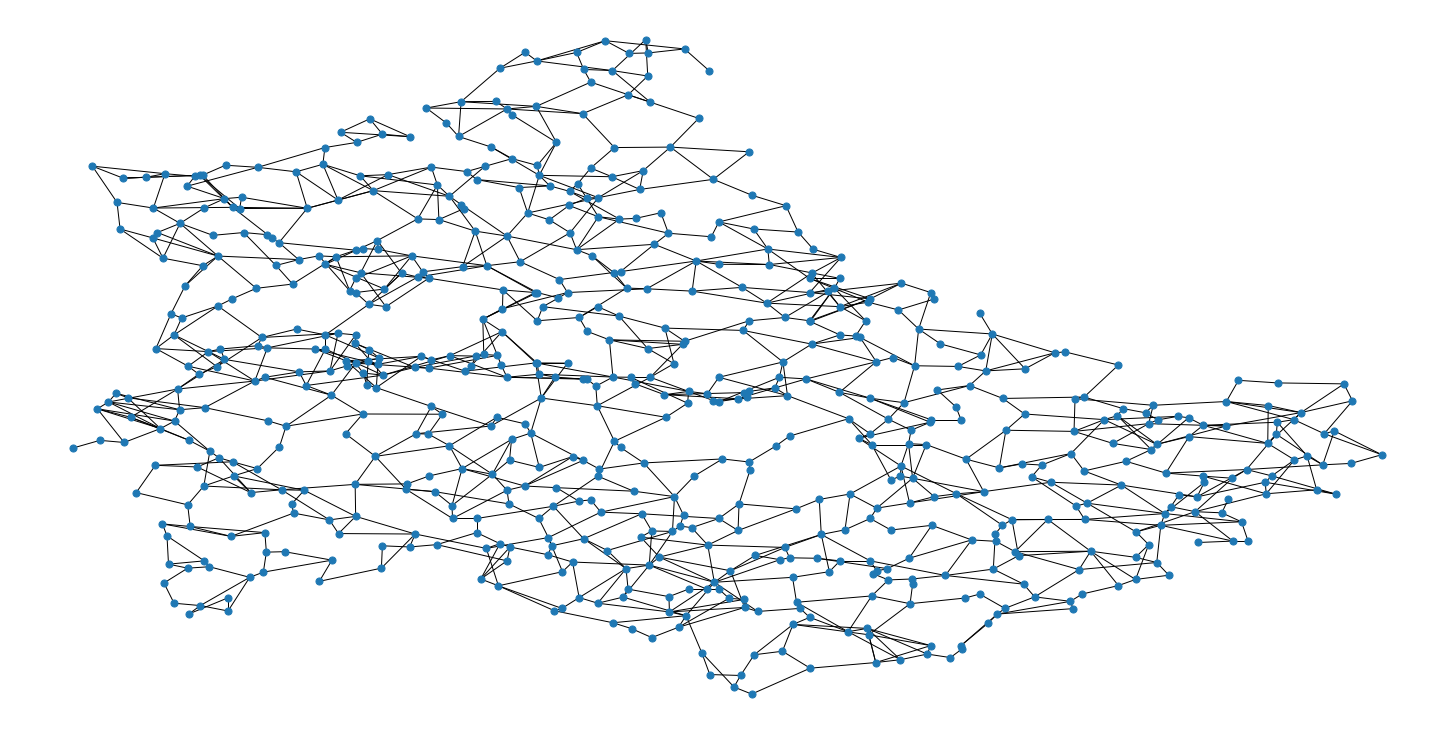

In [ ]:
#Graph 
G=nx.Graph()
G.add_weighted_edges_from(edges)
pos= dict([(df.id, (df.x, df.y)) for df in df_loc.itertuples()])
plt.figure(figsize=(20,10))
nx.draw(G,with_labels=False,pos=pos,node_size=50)


In [ ]:
all_nodes=[df.id for df in df_loc.itertuples()]
len(all_nodes)

634

123 

4 



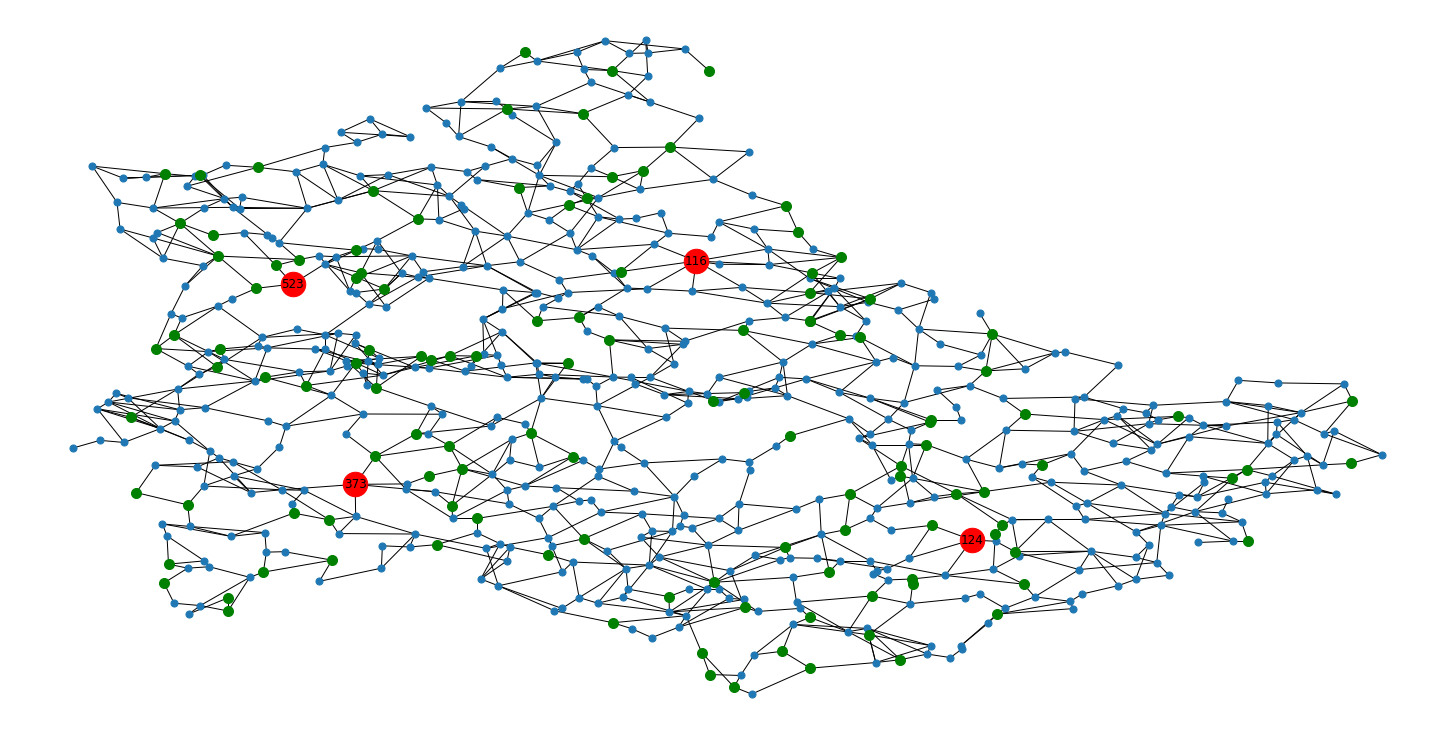

In [ ]:
#Draw with depot labels and separate coloured nodes
cust_loc_ids = [df.id for df in df_loc.loc[df_loc.is_customer==True].itertuples()]
print(len(cust_loc_ids),'\n')
depot_loc_ids = [df.id for df in df_loc.loc[df_loc.is_depot==True].itertuples()]
print(len(depot_loc_ids),'\n')

def show_network():
  plt.figure(figsize=(20,10))
  nx.draw(G,with_labels=False,pos=pos,node_size=50)
  nx.draw_networkx_nodes(G,pos,nodelist=depot_loc_ids,node_color='r',node_size=600,alpha=1);
  nx.draw_networkx_labels(G,pos,{k:k for k in depot_loc_ids});
  nx.draw_networkx_nodes(G,pos,nodelist=cust_loc_ids,node_color='g',node_size=100,alpha=1);

show_network()  

In [ ]:
#multi source shortest path gives a tuple of length dict and path dict which have the target node as keys
paths=nx.multi_source_dijkstra(G,depot_loc_ids)
#print(paths)
cust_paths=dict()
#cust_opath=[]

for i in paths[0].keys():
  if i in cust_loc_ids:
    cust_paths[i]=(paths[1][i],paths[0][i])
    #cust_opath.append(paths[1][i])
    
#print(cust_opath)
cust_paths

{5: ([116, 529, 47, 325, 1, 611, 5], 164.80147980117786),
 8: ([523, 99, 261, 225, 8], 79.83111028821038),
 13: ([373, 270, 13], 69.7636775739308),
 14: ([124, 208, 14], 22.330294086418878),
 22: ([373, 591, 240, 497, 0, 483, 605, 190, 513, 22], 230.29779181960456),
 27: ([523, 257, 46, 27], 83.81090108978688),
 29: ([523, 70, 402, 33, 622, 464, 385, 323, 29], 157.37546703437997),
 31: ([116, 484, 31], 77.8063113002674),
 32: ([116, 484, 447, 90, 528, 437, 459, 613, 64, 313, 228, 32],
  217.27982716918677),
 36: ([124, 208, 14, 36], 33.059858066844264),
 41: ([116, 529, 47, 325, 146, 624, 388, 546, 562, 38, 165, 416, 250, 41],
  335.80698758672906),
 44: ([373, 270, 13, 548, 86, 389, 44], 192.00108725409717),
 63: ([124, 199, 633, 260, 570, 449, 71, 63], 182.56425246903737),
 64: ([116, 484, 447, 90, 528, 437, 459, 613, 64], 132.36730281377777),
 65: ([116, 529, 47, 325, 146, 624, 388, 546, 562, 604, 269, 65],
  250.0470361306546),
 70: ([523, 70], 20.615528128088304),
 73: ([116, 484,

In [ ]:
c=0
grtDist=[]
D116=[]
D523=[]
D373=[]
D124=[]
DD116=[]
DD523=[]
DD373=[]
DD124=[]
for i in cust_paths.values():
  if i[0][0]==116:
    D116.append(i)
  elif i[0][0]==523:
    D523.append(i)
  elif i[0][0]==373:
    D373.append(i)
  elif i[0][0]==124:
    D124.append(i)
  if i[1]>125:
    c=c+1
    grtDist.append(i[0][-1])
#print(c, "customers are > 125 in distance from all depots, hence a penalty will be incurred when gas is delivered to them.")
#print(grtDist)



In [ ]:
#Finding all pairs shortest paths for convenience

allpairs=dict(nx.all_pairs_dijkstra_path_length(G))
#dict of dicts - 0:{0:,1:,----633:}, 1:{0:, 1:, 2:} , say matrix
dist_graph=np.array([[allpairs[i][j] for i in range(len(G.nodes))] for j in range(len(G.nodes))])
dist_graph[116][373]

397.1380815592918

In [ ]:

DD116= [item for element in D116 for item in element[0]]
print(DD116)
nodes116= list(dict.fromkeys(DD116))

DD124= [item for element in D124 for item in element[0]]
nodes124= list(dict.fromkeys(DD124))


DD373= [item for element in D373 for item in element[0]]
nodes373= list(dict.fromkeys(DD373))


DD523= [item for element in D523 for item in element[0]]
nodes523= list(dict.fromkeys(DD523))


[116, 398, 116, 484, 31, 116, 485, 380, 116, 600, 342, 243, 116, 600, 609, 584, 116, 484, 447, 90, 528, 116, 311, 481, 453, 116, 484, 447, 90, 528, 437, 116, 529, 47, 325, 146, 116, 484, 31, 265, 116, 484, 447, 90, 283, 80, 116, 311, 481, 453, 271, 116, 484, 447, 90, 528, 437, 459, 116, 529, 47, 325, 146, 624, 116, 600, 609, 584, 511, 116, 311, 481, 453, 101, 621, 116, 484, 447, 90, 528, 437, 459, 613, 64, 116, 529, 574, 422, 607, 471, 550, 116, 529, 47, 325, 1, 611, 5, 116, 529, 47, 325, 146, 624, 386, 113, 116, 311, 236, 356, 493, 390, 569, 116, 484, 31, 265, 290, 445, 45, 73, 116, 529, 47, 325, 146, 624, 386, 113, 308, 116, 311, 236, 356, 493, 575, 393, 116, 484, 447, 90, 283, 80, 355, 18, 468, 187, 110, 116, 484, 447, 90, 528, 437, 459, 613, 64, 313, 228, 32, 116, 529, 47, 325, 1, 611, 438, 387, 116, 484, 447, 90, 283, 80, 355, 18, 24, 598, 116, 529, 47, 325, 146, 624, 388, 546, 562, 604, 269, 65, 116, 529, 47, 325, 1, 611, 438, 387, 280, 515, 534, 116, 529, 47, 325, 146, 624, 388,

In [ ]:
print(nodes116)
print(len(nodes116))

[116, 398, 484, 31, 485, 380, 600, 342, 243, 609, 584, 447, 90, 528, 311, 481, 453, 437, 529, 47, 325, 146, 265, 283, 80, 271, 459, 624, 511, 101, 621, 613, 64, 574, 422, 607, 471, 550, 1, 611, 5, 386, 113, 236, 356, 493, 390, 569, 290, 445, 45, 73, 308, 575, 393, 355, 18, 468, 187, 110, 313, 228, 32, 438, 387, 24, 598, 388, 546, 562, 604, 269, 65, 280, 515, 534, 38, 165, 416, 250, 41, 383, 436, 126, 77]
85


In [ ]:
# G116=G.subgraph(nodes116)
# plt.figure(figsize=(20,10))
# nx.draw(G116,with_labels=False,pos=pos,node_size=400)
# nx.draw_networkx_nodes(G116,pos,nodelist=[116],node_color='r',node_size=600,alpha=1);
# nx.draw_networkx_labels(G116,pos,{k:k for k in nodes116});
# nx.draw_networkx_nodes(G116,pos,nodelist={k: k for k in cust_loc_ids if k not in [116] and k in nodes116},node_color='g',node_size=600,alpha=1);


In [ ]:
# G523=G.subgraph(nodes523)
# plt.figure(figsize=(20,10))
# nx.draw(G523,with_labels=False,pos=pos,node_size=400)
# nx.draw_networkx_nodes(G523,pos,nodelist=[523],node_color='r',node_size=600,alpha=1);
# nx.draw_networkx_labels(G523,pos,{k:k for k in nodes523});
# nx.draw_networkx_nodes(G523,pos,nodelist={k: k for k in cust_loc_ids if k not in [523] and k in nodes523},node_color='g',node_size=600,alpha=1);


In [ ]:
# G373=G.subgraph(nodes373)
# plt.figure(figsize=(20,10))
# nx.draw(G373,with_labels=False,pos=pos,node_size=400)
# nx.draw_networkx_nodes(G373,pos,nodelist=[373],node_color='r',node_size=600,alpha=1);
# nx.draw_networkx_labels(G373,pos,{k:k for k in nodes373});
# nx.draw_networkx_nodes(G373,pos,nodelist={k: k for k in cust_loc_ids if k not in [373] and k in nodes373},node_color='g',node_size=600,alpha=1);


In [ ]:
# G124=G.subgraph(nodes124)
# plt.figure(figsize=(20,10))
# nx.draw(G124,with_labels=False,pos=pos,node_size=800)
# nx.draw_networkx_nodes(G124,pos,nodelist=[124],node_color='r',node_size=1000,alpha=1);
# nx.draw_networkx_labels(G124,pos,{k:k for k in nodes124});
# nx.draw_networkx_nodes(G124,pos,nodelist={k: k for k in cust_loc_ids if k not in [124] and k in nodes124},node_color='g',node_size=800,alpha=1);


In [ ]:
#lorry has to deliver fuel to fill tanks of all customers
df_loc[(df_loc.is_customer==True) & (df_loc.emptiness>0)].count()

index          123
id             123
x              123
y              123
is_depot       123
is_customer    123
capacity       123
level          123
emptiness      123
emptinessP     123
dtype: int64

In [ ]:
#Setting new header for lorries
pdjson['delivered']=0
pdjson.head(10)

,lorry_id,lorryID,ID,capacity,cpm,cptm,delivered
0,116-1,116,1,12,1.5,1.0,0
1,116-0,116,0,5,1.0,1.5,0
2,124-6,124,6,22,2.0,0.5,0
3,124-7,124,7,22,2.0,0.5,0
4,124-3,124,3,12,1.5,1.0,0
5,124-4,124,4,12,1.5,1.0,0
6,124-5,124,5,12,1.5,1.0,0
7,124-0,124,0,5,1.0,1.5,0
8,124-1,124,1,5,1.0,1.5,0
9,124-2,124,2,5,1.0,1.5,0


In [ ]:
#Setting new header for customer locations
df_loc['filled']=0
df_loc.head(10)

,index,id,x,y,is_depot,is_customer,capacity,level,emptiness,emptinessP,filled
0,0,0,49525.5556,5940.5556,False,False,NaN,NaN,NaN,NaN,0
1,1,1,49738.8889,6345.0000,False,False,NaN,NaN,NaN,NaN,0
2,2,2,49608.3333,6405.8333,False,False,NaN,NaN,NaN,NaN,0
3,3,3,49796.6667,6155.5556,False,False,NaN,NaN,NaN,NaN,0
4,4,4,49828.6111,5764.7222,False,False,NaN,NaN,NaN,NaN,0
5,5,5,49757.7778,6353.3333,False,True,0.5,0.4,0.1,20.0,0
6,6,6,49716.3889,6490.0000,False,False,NaN,NaN,NaN,NaN,0
7,7,7,49533.3333,6316.6667,False,False,NaN,NaN,NaN,NaN,0
8,8,8,49616.6667,6233.3333,False,True,2.0,1.8,0.2,10.0,0
9,9,9,49501.3889,6352.7778,False,False,NaN,NaN,NaN,NaN,0


In [ ]:
#Given a set of nodes and a depot, the function filters the customer nodes

def findCustomerNodes(depot, nodes):
  cnt=0
  custnodes=[depot]
  for i in nodes:
    if i in cust_loc_ids:
      custnodes.append(i)
  return custnodes

custnodes116=findCustomerNodes(116, nodes116)
custnodes124=findCustomerNodes(124, nodes124)
custnodes373=findCustomerNodes(373, nodes373)
custnodes523=findCustomerNodes(523, nodes523)
print(len(custnodes116))
print(len(custnodes124))
print(len(custnodes373))
print(len(custnodes523))
print(custnodes116)
print(custnodes124)
print(custnodes373)
print(custnodes523)

33
41
31
22
[116, 398, 31, 380, 243, 584, 528, 453, 437, 146, 265, 80, 271, 459, 624, 511, 621, 64, 550, 5, 113, 569, 73, 308, 393, 110, 32, 387, 598, 65, 534, 41, 77]
[124, 14, 542, 204, 36, 633, 260, 206, 411, 476, 254, 539, 397, 220, 171, 147, 507, 418, 449, 169, 264, 245, 446, 408, 160, 105, 63, 210, 118, 372, 177, 566, 202, 130, 214, 374, 400, 324, 175, 362, 606]
[373, 270, 180, 520, 431, 200, 13, 100, 337, 103, 78, 497, 377, 531, 474, 86, 547, 364, 172, 543, 205, 294, 455, 389, 44, 190, 274, 22, 144, 216, 135]
[523, 70, 257, 235, 183, 519, 225, 8, 27, 276, 378, 491, 255, 391, 136, 603, 585, 632, 29, 332, 82, 94]


In [ ]:
# # hardcoded
# custnodes523.append(172)
# custnodes373.remove(172)
# custnodes523.remove(29)
# custnodes373.append(29)
#custnodes373, custnodes523

In [ ]:
#The function returns final path of customers by connecting nearest nodes

def makeSortedCustPathList(depot, custNodes, G): 
    print('length of customers', len(custNodes))
    sortedCustomers=[depot]
    current=depot
    nearest=custNodes[1]
    for j in range(len(custNodes)-1):
        distmin=10000
        for i in custNodes:
            if i not in sortedCustomers:
                
                #dist=nx.dijkstra_path_length(G, current, i)
                dist=dist_graph[current, i]
                #print("Distance from-to customer node", current, ' to ', i," is ",dist)
                if distmin>dist:
                    distmin=dist
                    nearest=i
        sortedCustomers.append(nearest)
        current=nearest
        #print("nearest is ",nearest)
    #print(sortedCustomers)

    pathFinal=[depot]
    for i in range(len(sortedCustomers)-1):
        p=nx.dijkstra_path(G, sortedCustomers[i], sortedCustomers[i+1])
        #print('path to', sortedCustomers[i+1], ':', p)
        pathFinal.extend(p[1:])
    #path124Final.extend(nx.dijkstra_path(G, visited[-1], 116))
    #print(pathFinal)   

    return sortedCustomers, pathFinal 

In [ ]:
#The function returns a dictionary of customer edges with distance and fuel requirement

def createSerialcustLorryDict(depot, sortedCustomers):
  custDetails=dict()
  for i in range(len(sortedCustomers)-1):
    if sortedCustomers[i+1] in cust_loc_ids:   
      custDetails[i]=[depot, sortedCustomers[i], sortedCustomers[i+1], dist_graph[sortedCustomers[i], sortedCustomers[i+1]], df_loc[df_loc.id==sortedCustomers[i+1]]['emptiness'].item()- df_loc[df_loc.id==sortedCustomers[i+1]]['filled'].item()]
      #p=nx.dijkstra_path_length(G, sortedCustomers[i], sortedCustomers[i+1])    
      #custDetails[i]=[depot, sortedCustomers[i], sortedCustomers[i+1], p, df_loc[df_loc.id==sortedCustomers[i+1]]['emptiness'].item()- df_loc[df_loc.id==sortedCustomers[i+1]]['filled'].item()]

  from copy import deepcopy
  custDetailsCopy = deepcopy(custDetails)

  return custDetails, custDetailsCopy


In [ ]:
def drawFullGraph():
  show_network()
  ed=[]
  ed.append(list(zip(path116Final, path116Final[1:])))
  for edge in ed:
    nx.draw_networkx_edges(
      G,
      pos,
      edgelist=list(edge),
      alpha=1,
      edge_color='r',
      width=10.0
    )
  ed=[]
  ed.append(list(zip(path124Final, path124Final[1:])))
  for edge in ed:
    nx.draw_networkx_edges(
      G,
      pos,
      edgelist=list(edge),
      alpha=1,
      edge_color='g',
      width=10.0
    )
  ed=[]
  ed.append(list(zip(path373Final, path373Final[1:])))
  for edge in ed:
    nx.draw_networkx_edges(
      G,
      pos,
      edgelist=list(edge),
      alpha=1,
      edge_color='b',
      width=10.0
    )
  ed=[]
  ed.append(list(zip(path523Final, path523Final[1:])))
  for edge in ed:
    nx.draw_networkx_edges(
      G,
      pos,
      edgelist=list(edge),
      alpha=1,
      edge_color='y',
      width=10.0
    )
  ed=[]
  ed.append(list(zip(pathRem116, pathRem116[1:])))
  for edge in ed:
    nx.draw_networkx_edges(
      G,
      pos,
      edgelist=list(edge),
      alpha=1,
      edge_color='orange',
      width=10.0
    )

In [ ]:
#The function draws a graph to mark the shortest possible paths taken over the superset nodes
def drawGraph(G, depot, nodes, pathFinal):
    G1=G.subgraph(nodes)
    plt.figure(figsize=(20,10))
    nx.draw(G1,with_labels=False,pos=pos,node_size=400)
    nx.draw_networkx_nodes(G1,pos,nodelist=[depot],node_color='r',node_size=600,alpha=1);
    nx.draw_networkx_labels(G1,pos,{k:k for k in nodes});
    nx.draw_networkx_nodes(G1,pos,nodelist={k: k for k in cust_loc_ids if k not in [depot] and k in nodes},node_color='g',node_size=600,alpha=1);
    #list(tuple(ed116[0]))
    ed=[]
    ed.append(list(zip(pathFinal, pathFinal[1:])))
    for edge in ed:
      nx.draw_networkx_edges(
        G1,
        pos,
        edgelist=list(edge),
        alpha=1,
        edge_color='r',
        width=10.0
    )
        
    return G1

In [ ]:
# To check total capacity of a depot vs requirement of customers surrounding the depot

def checkTotalCapacityVsRequirement(depot, custDetails, sumCapacity=0):
  #Total capacty of lorries starting from depot 116
  if sumCapacity==0:
    totalLorryCapacity=pdjson[pdjson.lorryID==str(depot)]['capacity'].sum()
  else:
    totalLorryCapacity=sumCapacity
  #Total fuel requirement of the nearest neighbours of depot 116
  totalFuelRequirement=0
  for node in custDetails.keys():
    if custDetails[node][4]!=-99:
      totalFuelRequirement=totalFuelRequirement+custDetails[node][4]
  return totalLorryCapacity, totalFuelRequirement

In [ ]:
#To find previous key of lorry dictionary
def findPreviousKey(lorryDict, customer, lorry_id):
  test_key = (customer, lorry_id)  
  temp = list(lorryDict) 
  try: 
      res = temp[temp.index(test_key) - 1] 
  except (ValueError, IndexError): 
      res = None
  return res


  

In [ ]:
#The function contains the complete delivery plan and takes in customer details dict and total fuel requirement value as input

def planDelivery(depot, custDetails, totalFuelRequirement):
  lorry=dict()
  flag=0
  lorryDest=dict()
  i=0
  startfromcust=custDetails[0][2]
  for lorry_id in pdjson[pdjson.lorryID==str(depot)]['lorry_id'].values:
    capacity=pdjson.loc[pdjson.lorry_id==lorry_id,'capacity'].item()
    lorryQuantity=totalFuelRequirement+0.01 if totalFuelRequirement<=capacity else capacity
    lorryCpm=pdjson.loc[pdjson.lorry_id==lorry_id,'cpm'].item()
    lorryCptm=pdjson.loc[pdjson.lorry_id==lorry_id,'cptm'].item()
    depot_cust_dist=dist_graph[depot][startfromcust]
    #depot_cust_dist= nx.dijkstra_path_length(G, depot, startfromcust)    
    if depot_cust_dist !=0:
      depot_cust_cost=depot_cust_dist*(lorryCpm + ((lorryQuantity)* lorryCptm))
      lorry[(startfromcust, lorry_id+"-depot")]=[lorry_id, capacity, 0, lorryQuantity, 0, 0]
    sum=0
    for item in custDetails.keys():    
      lorryFilled=pdjson.loc[pdjson.lorry_id==lorry_id,'delivered'].item()
      custRequirement=df_loc.loc[df_loc.id==custDetails[item][2],'emptiness'].item()
      custFilled=df_loc.loc[df_loc.id==custDetails[item][2],'filled'].item()
      custDistance=custDetails[item][3]
      lorryRemainingfuel= lorryQuantity - lorryFilled
      custUpdatedrequirement= custRequirement - custFilled
      if lorryQuantity==lorryFilled:
        startfromcust=custDetails[item-1][2]        
        break;
      quantityCarried=round(lorryQuantity,2)
      if lorryRemainingfuel >= custUpdatedrequirement:
        if custRequirement > custFilled:                
          lorry[(custDetails[item][2], lorry_id)]=[lorry_id, capacity, custUpdatedrequirement, quantityCarried, custDistance, 0]
          res=findPreviousKey(lorry, custDetails[item][2], lorry_id)            
          quantityCarried= round(lorry[res][3] - lorry[res][2], 2)
          custCost=custDistance*(lorryCpm + ((quantityCarried)* lorryCptm))
          lorry[(custDetails[item][2], lorry_id)][3]=quantityCarried
          lorry[(custDetails[item][2], lorry_id)][-1]=round(custCost, 2)
          pdjson.loc[pdjson.lorry_id==lorry_id, 'delivered']= lorryFilled+ (custUpdatedrequirement)
          df_loc.loc[df_loc.id==custDetails[item][2], 'filled']= df_loc.loc[df_loc.id==custDetails[item][2], 'filled'].item()+ custUpdatedrequirement
          custDetails[item].append(lorry_id)
          custDetails[item].append(custUpdatedrequirement)
          if flag==1:
            custDetails[item].append(df_loc.loc[df_loc.id==custDetails[item][2],'filled'].item())
            flag=0
      else:
        if custRequirement > custFilled:
          flag=1            
          lorry[(custDetails[item][2], lorry_id)]=[lorry_id, capacity, lorryRemainingfuel, quantityCarried, custDistance, 0]
          res=findPreviousKey(lorry, custDetails[item][2], lorry_id)            
          quantityCarried= round(lorry[res][3] - lorry[res][2], 2)
          custCost= custDistance*(lorryCpm + ((quantityCarried)* lorryCptm)) 
          lorry[(custDetails[item][2], lorry_id)][-1]=round(custCost, 2)
          lorry[(custDetails[item][2], lorry_id)][3]=quantityCarried
          pdjson.loc[pdjson.lorry_id==lorry_id, 'delivered']= lorryFilled+ (lorryRemainingfuel)
          df_loc.loc[df_loc.id==custDetails[item][2], 'filled']= df_loc.loc[df_loc.id==custDetails[item][2], 'filled'].item()+ lorryRemainingfuel
          custDetails[item].append(lorry_id)
          custDetails[item].append(df_loc.loc[df_loc.id==custDetails[item][2], 'filled'].item())
      if (custDetails[item][2], lorry_id+"-depot") in lorry.keys():      
        
        lorry[(custDetails[item][2], lorry_id)][4]=dist_graph[depot][custDetails[item][2]]
        #lorry[(custDetails[item][2], lorry_id)][4]=nx.dijkstra_path_length(G, depot, custDetails[item][2])
        lorry[(custDetails[item][2], lorry_id)][3]=round(lorryQuantity,2)
        lorry[(custDetails[item][2], lorry_id)][5]= lorry[(custDetails[item][2], lorry_id)][4]*(lorryCpm + ((lorryQuantity)* lorryCptm))   
                 
      if lorryRemainingfuel >0:
        lorryDest[lorry_id]=custDetails[item][2]      
      sum=sum+custDetails[item][-1]
  # print(lorry) 
  # print(custDetails)
  # print(lorryDest)
    if sum==totalFuelRequirement:
      break;
  #print("end ", startfromcust)
  return lorry, custDetails, lorryDest
        


In [ ]:
def findTotalDistanceCost(deliveryDetails):
    distSum=0
    costSum=0
    for (x,y) in deliveryDetails.keys():
      distSum=distSum+ deliveryDetails[(x,y)][4]
      costSum=costSum+ deliveryDetails[(x,y)][5]
    return distSum, costSum

In [ ]:
def findFuelRequirement(depot, custDetails):
  fuelRequired=dict()
  for item in custDetails.keys():
    if custDetails[item][4] != custDetails[item][-1]:
      fuelRequired[custDetails[item][2]]=[depot,custDetails[item][4]-custDetails[item][-1]]
    if len(custDetails[item])<=5:
      fuelRequired[custDetails[item][2]]=[depot,custDetails[item][4]]
  
  sum=0
  for x in fuelRequired.keys():
    sum=sum+fuelRequired[x][1]
  return sum, fuelRequired

In [ ]:
#The main function which invokes all other functions for delivery execution

def ExecuteDelivery(depot, G, custnodes, sumCapacity=0):
  pathFinal=[]
  visited=[]
  visited, pathFinal=makeSortedCustPathList(depot, custnodes, G)
  #print(len(pathFinal))
  #print(len(visited))

  custDetails, custDetailsprev= createSerialcustLorryDict(depot, visited)
  #print(custDetails)

  totalLorryCapacity, totalFuelRequirement= checkTotalCapacityVsRequirement(depot, custDetails, sumCapacity)
  #print(totalLorryCapacity, totalFuelRequirement)

  # deliveryDetails, updatedCustDetails, dest= planDeliveryOld(depot, custDetails, totalFuelRequirement)
  deliveryDetails, updatedCustDetails, dest= planDelivery(depot, custDetails, totalFuelRequirement)
  # print(deliveryDetails) 
  # print(updatedCustDetails)
  # print(dest)

  distSum, costSum= findTotalDistanceCost(deliveryDetails)
  # print(distSum, costSum)

  fuelRequired=dict()
  remainingFuelRequired=0

  remainingFuelRequired, fuelRequired=findFuelRequirement(depot, custDetails)
  # print(remainingFuelRequired, fuelRequired)
  
  return pathFinal, visited, custDetailsprev, totalLorryCapacity, totalFuelRequirement, updatedCustDetails, deliveryDetails, dest, distSum, costSum, remainingFuelRequired, fuelRequired

In [ ]:
path116Final, visited116, cl116prev, totalLorryCapacity116, totalFuelRequirement116, cl116, lorry116, dest, distSum116, costSum116, remainingFuelRequired, fuelRequired= ExecuteDelivery(116, G, custnodes116)
print('path116Final= ', path116Final,'\n', 'visited116=', visited116, '\n','cl116prev=',cl116prev,'\n', 'totalLorryCapacity116=',totalLorryCapacity116,'\n', 'totalFuelRequirement116=',totalFuelRequirement116,'\n', 'updatedcl116=',cl116,'\n', 'lorry116=',lorry116,'\n', 'dest=',dest,'\n', 'distSum=',distSum116,'\n', 'costSum=',costSum116,'\n', 'remainingFuelRequired=',remainingFuelRequired,'\n', 'fuelRequired=',fuelRequired)

length of customers 33
path116Final=  [116, 398, 583, 481, 453, 271, 453, 101, 621, 98, 283, 80, 283, 90, 528, 437, 459, 613, 64, 613, 68, 218, 290, 265, 31, 380, 243, 380, 153, 584, 511, 410, 602, 308, 113, 5, 524, 386, 624, 146, 624, 388, 546, 550, 546, 562, 604, 269, 65, 387, 280, 515, 534, 6, 41, 6, 563, 126, 77, 126, 563, 238, 434, 242, 305, 604, 562, 471, 279, 349, 429, 625, 493, 390, 569, 393, 237, 163, 595, 307, 525, 598, 24, 530, 419, 110, 187, 468, 18, 478, 333, 553, 313, 228, 32, 73] 
 visited116= [116, 398, 453, 271, 621, 80, 528, 437, 459, 64, 265, 31, 380, 243, 584, 511, 308, 113, 5, 624, 146, 550, 65, 387, 534, 41, 77, 569, 393, 598, 110, 32, 73] 
 cl116prev= {0: [116, 116, 398, 43.501309048006036, 0.89], 1: [116, 398, 453, 66.1578929716007, 0.61], 2: [116, 453, 271, 23.38118096802995, 0.9], 3: [116, 271, 621, 56.153880277038965, 0.24], 4: [116, 621, 80, 96.28002152670595, 0.22999999999999998], 5: [116, 80, 528, 46.12449089320675, 0.12], 6: [116, 528, 437, 0.878354245165

In [ ]:
dist_graph[398,453]

66.1578929716007

In [ ]:
j=nx.dijkstra_path(G, 398, 453)
k=nx.dijkstra_path(G116, 398, 453)
j, k

([398, 583, 481, 453], [398, 583, 481, 453])

In [ ]:
for node in path116Final:
  if node not in nodes116:
    nodes116.append(node)

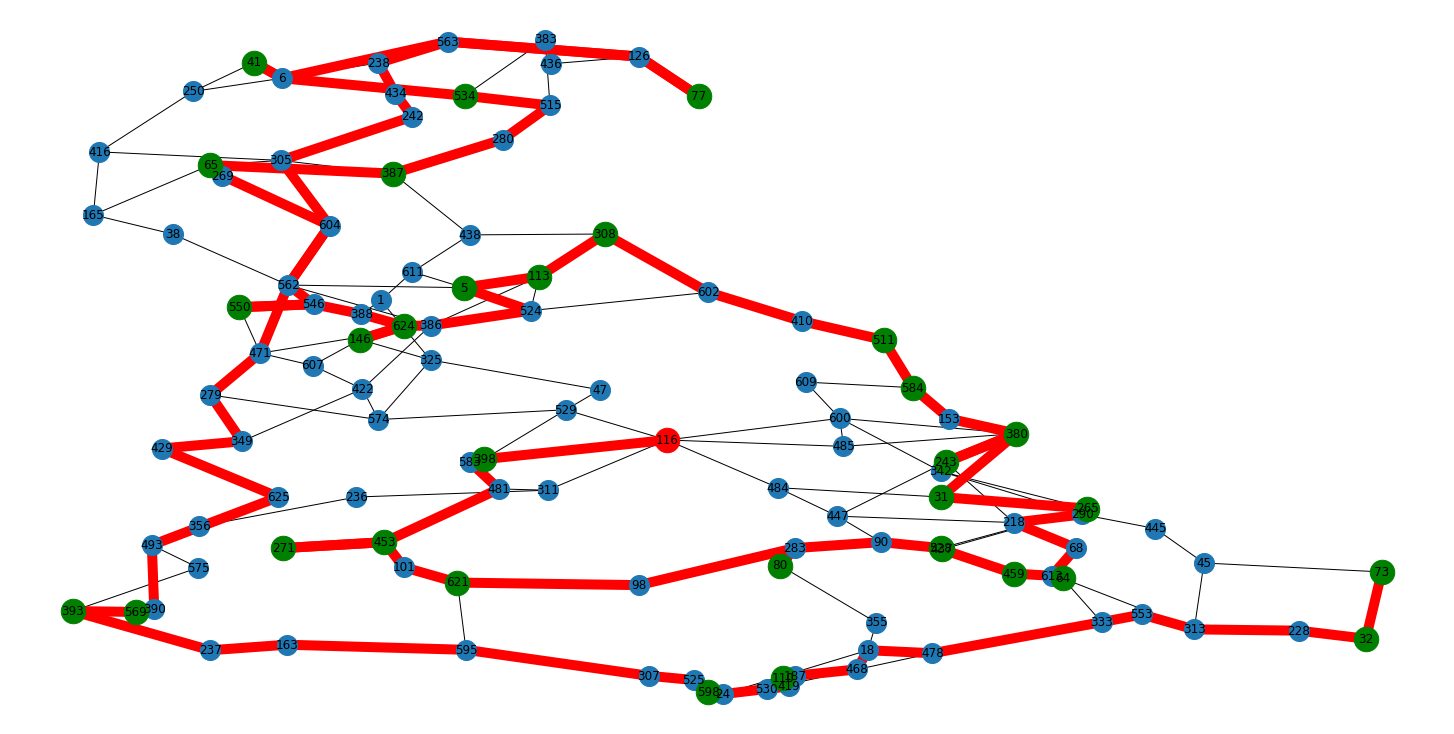

In [ ]:
G116=drawGraph(G, 116, nodes116, path116Final)

In [ ]:
#The function fills fuel in required lorries in case of fuel requirement after 1st round of delivery by all lorries.

def fillRequiredLorries(depot, remainingFuelRequired):
  backtodepot=dict()
  sumCapacity=0
  for lorry_id in pdjson[pdjson.lorryID==str(depot)]['lorry_id'].values:
    sumCapacity=sumCapacity+ pdjson[pdjson.lorry_id==lorry_id]['capacity'].item()
    
    pdjson.loc[pdjson.lorry_id==lorry_id, 'delivered']=0
    disttoDepot=dist_graph[dest[lorry_id]][depot]
    #disttoDepot= nx.dijkstra_path_length(G, dest[lorry_id], depot)
    
    costtoDepot= disttoDepot*(pdjson[pdjson.lorry_id==lorry_id]['cpm'].item())
    backtodepot[(dest[lorry_id], lorry_id+"-to-depot")]=[lorry_id, pdjson[pdjson.lorry_id==lorry_id]['capacity'].item(),0, 0, disttoDepot, costtoDepot ]
    if sumCapacity>= remainingFuelRequired:  
      break;
    else:
      continue;       
  return sumCapacity, backtodepot





In [ ]:
# If fuel is required, 2nd round filling is done for required lorries

backtodepot116=dict()
if len(fuelRequired)>0:
  # pdjson.sort_values(by=['lorryID','capacity'], ascending=[True, True], inplace=True)
  # pdjson = pdjson.reset_index(drop=True)
  sumCapacity, backtodepot116= fillRequiredLorries(116, remainingFuelRequired)
  lorry116.update(backtodepot116)
  print('sumCapacity=',sumCapacity,'\n', 'backtodepot116=',backtodepot116,'\n', 'lorry116=',lorry116)

  distSum116, costSum116= findTotalDistanceCost(lorry116)
  print(distSum116, costSum116)

  nodesRem116= [116]
  custNodes116=fuelRequired.keys()
  nodesRem116.extend(custNodes116)
  print(nodesRem116)
  pathRem116, visitedRem116, clRem116prev, totalLorryCapacityRem116, totalFuelRequirementRem116, clRem116, lorryRem116, destRem, distRemSum116, costRemSum116, remainingFuelRequired, fuelRequired= ExecuteDelivery(116, G, nodesRem116, sumCapacity)
  print('path116Final= ', pathRem116,'\n', 'visited116=', visitedRem116, '\n','cl116prev=',clRem116prev,'\n', 'totalLorryCapacity116=',totalLorryCapacityRem116,'\n', 'totalFuelRequirement116=',totalFuelRequirementRem116,'\n', 'updatedcl116=',clRem116,'\n', 'lorry116=',lorryRem116,'\n', 'dest=',destRem,'\n', 'distSum=',distRemSum116,'\n', 'costSum=',costRemSum116,'\n', 'remainingFuelRequired=',remainingFuelRequired,'\n', 'fuelRequired=',fuelRequired)
  # pdjson.sort_values(by=['lorryID','capacity'], ascending=[True, False], inplace=True)
  # pdjson = pdjson.reset_index(drop=True)



sumCapacity= 12 
 backtodepot116= {(146, '116-1-to-depot'): ['116-1', 12, 0, 0, 109.68055124477914, 164.5208268671687]} 
 lorry116= {(398, '116-1-depot'): ['116-1', 12, 0, 12, 0, 0], (398, '116-1'): ['116-1', 12, 0.89, 12, 43.501309048006036, 587.2676721480815], (453, '116-1'): ['116-1', 12, 0.61, 11.11, 66.1578929716007, 834.25], (271, '116-1'): ['116-1', 12, 0.9, 10.5, 23.38118096802995, 280.57], (621, '116-1'): ['116-1', 12, 0.24, 9.6, 56.153880277038965, 623.31], (80, '116-1'): ['116-1', 12, 0.22999999999999998, 9.36, 96.28002152670595, 1045.6], (528, '116-1'): ['116-1', 12, 0.12, 9.13, 46.12449089320675, 490.3], (437, '116-1'): ['116-1', 12, 0.94, 9.01, 0.8783542451651771, 9.23], (459, '116-1'): ['116-1', 12, 1.98, 8.07, 22.787922943961902, 218.08], (64, '116-1'): ['116-1', 12, 0.96, 6.09, 11.727034501884429, 89.01], (265, '116-1'): ['116-1', 12, 0.48, 5.13, 64.24066353131767, 425.92], (31, '116-1'): ['116-1', 12, 0.56, 4.65, 34.1666341463407, 210.12], (380, '116-1'): ['116-1', 12

In [ ]:

if remainingFuelRequired==0:
  totalDistSum116=distSum116+distRemSum116
  totalCostSum116=costSum116+costRemSum116
  print(totalDistSum116, totalCostSum116)

2629.0608332170777 15248.028418416932


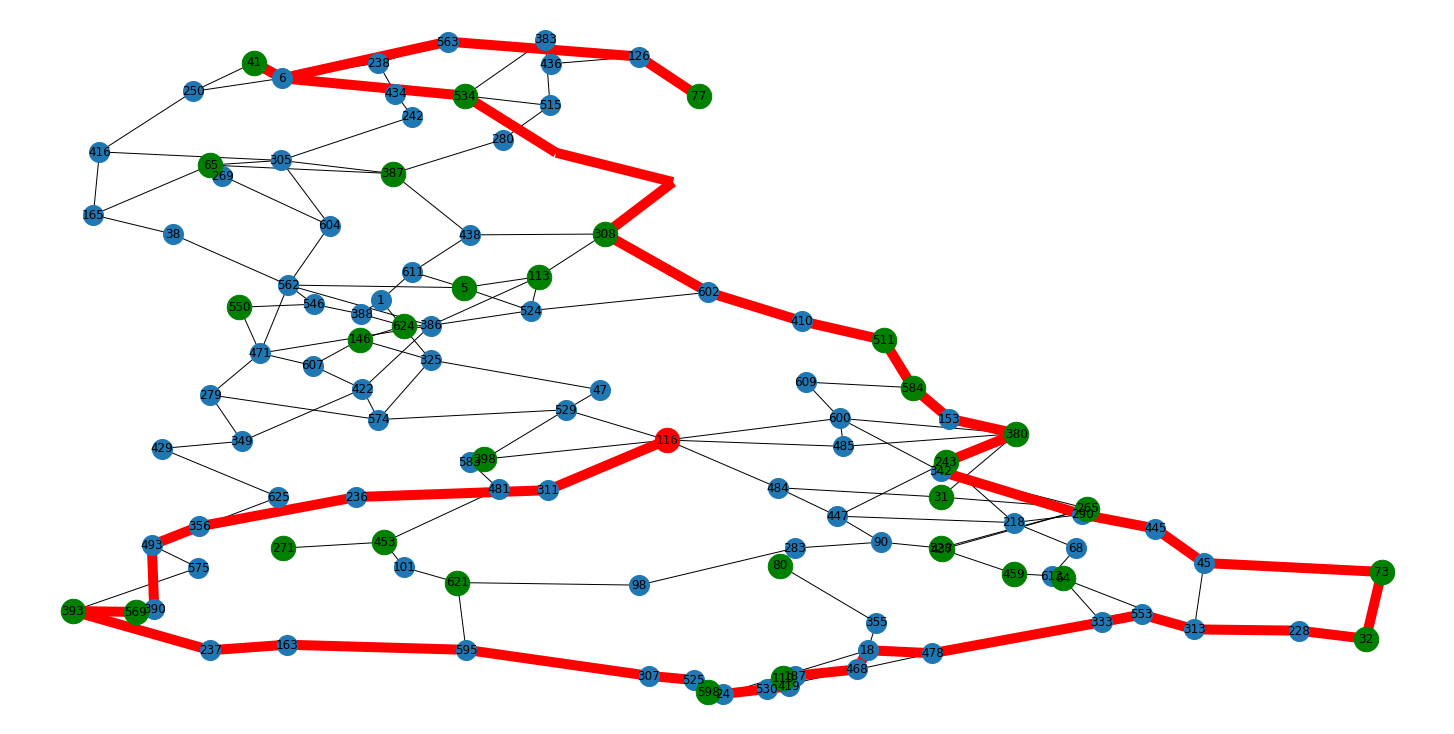

In [ ]:
G116_rem=drawGraph(G116, 116, nodes116, pathRem116)

In [ ]:
path523Final, visited523, cl523prev, totalLorryCapacity523, totalFuelRequirement523, cl523, lorry523, dest, distSum523, costSum523, remainingFuelRequired, fuelRequired= ExecuteDelivery(523, G, custnodes523)
print('path523Final= ', path523Final,'\n', 'visited523=', visited523, '\n','cl523prev=',cl523prev,'\n', 'totalLorryCapacity523=',totalLorryCapacity523,'\n', 'totalFuelRequirement523=',totalFuelRequirement523,'\n', 'updatedcl523=',cl523,'\n', 'lorry523=',lorry523,'\n', 'dest=',dest,'\n', 'distSum=',distSum523,'\n', 'costSum=',costSum523,'\n', 'remainingFuelRequired=',remainingFuelRequired,'\n', 'fuelRequired=',fuelRequired)


length of customers 22
path523Final=  [523, 70, 519, 491, 27, 46, 257, 235, 184, 99, 183, 99, 261, 225, 8, 119, 463, 378, 88, 57, 255, 585, 302, 420, 82, 151, 329, 632, 612, 94, 490, 491, 519, 618, 444, 401, 276, 391, 317, 136, 579, 603, 291, 176, 323, 29, 440, 375, 285, 172, 12, 508, 332] 
 visited523= [523, 70, 519, 491, 27, 257, 235, 183, 225, 8, 378, 255, 585, 82, 632, 94, 276, 391, 136, 603, 29, 332] 
 cl523prev= {0: [523, 523, 70, 20.615528128088304, 1.46], 1: [523, 70, 519, 43.51895705850624, 0.21000000000000002], 2: [523, 519, 491, 43.87303764386437, 0.33999999999999997], 3: [523, 491, 27, 22.94988555352732, 1.02], 4: [523, 27, 257, 60.02890691520271, 0.19999999999999996], 5: [523, 257, 235, 14.299513287171509, 0.36], 6: [523, 235, 183, 34.81283361281553, 0.3999999999999999], 7: [523, 183, 225, 45.83346541746845, 0.64], 8: [523, 225, 8, 7.222223077418047, 0.19999999999999996], 9: [523, 8, 378, 35.202607146209274, 0.54], 10: [523, 378, 255, 95.58488438074119, 0.16999999999999998

In [ ]:
for node in path523Final:
  if node not in nodes523:
    nodes523.append(node)

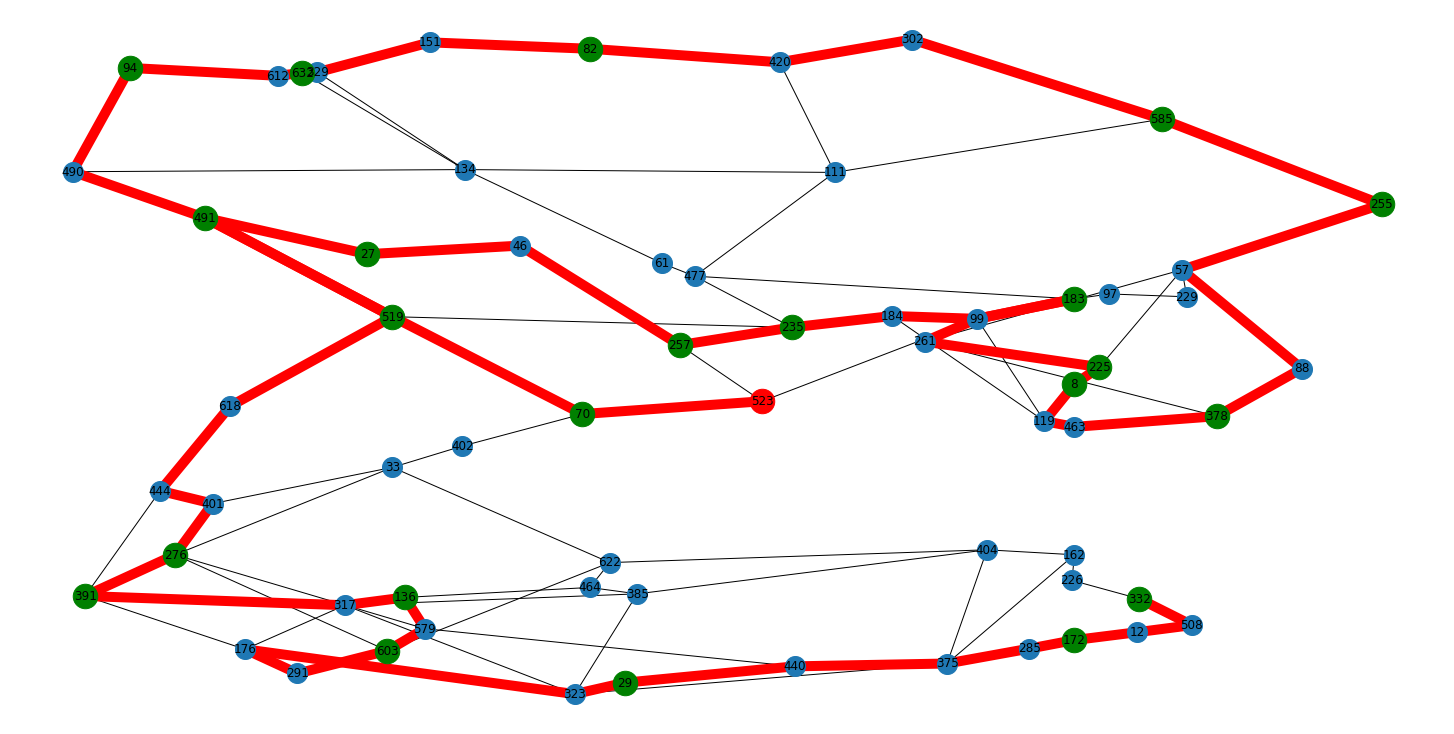

In [ ]:
G523=drawGraph(G, 523, nodes523, path523Final)


In [ ]:
backtodepot523=dict()
distRemSum523=0
costRemSum523=0
if len(fuelRequired)>0:
  sumCapacity, backtodepot523= fillRequiredLorries(523, remainingFuelRequired)
  lorry523.update(backtodepot523)
  print('sumCapacity=',sumCapacity,'\n', 'backtodepot523=',backtodepot523,'\n', 'lorry523=',lorry523)

  distSum523, costSum523= findTotalDistanceCost(lorry523)
  print(distSum523, costSum523)

  nodesRem523= [523]
  custNodes523=fuelRequired.keys()
  nodesRem523.extend(custNodes523)
  print(nodesRem523)
  pathRem523, visitedRem523, clRem523prev, totalLorryCapacityRem523, totalFuelRequirementRem523, clRem523, lorryRem523, destRem, distRemSum523, costRemSum523, remainingFuelRequired, fuelRequired= ExecuteDelivery(523, G523, nodesRem523, sumCapacity)
  print('path523Final= ', pathRem523,'\n', 'visited523=', visitedRem523, '\n','cl523prev=',clRem523prev,'\n', 'totalLorryCapacity523=',totalLorryCapacityRem523,'\n', 'totalFuelRequirement523=',totalFuelRequirementRem523,'\n', 'updatedcl523=',clRem523,'\n', 'lorry523=',lorryRem523,'\n', 'dest=',destRem,'\n', 'distSum=',distRemSum523,'\n', 'costSum=',costRemSum523,'\n', 'remainingFuelRequired=',remainingFuelRequired,'\n', 'fuelRequired=',fuelRequired)
  G523_rem=drawGraph(G523, 523, nodes523, pathRem523)


In [ ]:
if remainingFuelRequired==0:
  totalDistSum523=distSum523+distRemSum523
  totalCostSum523=costSum523+costRemSum523
  print(totalDistSum523, totalCostSum523)
  

1041.5610368502312 5849.759809122749


In [ ]:
path373Final, visited373, cl373prev, totalLorryCapacity373, totalFuelRequirement373, cl373, lorry373, dest, distSum373, costSum373, remainingFuelRequired, fuelRequired= ExecuteDelivery(373, G, custnodes373)
print('path373Final= ', path373Final,'\n', 'visited373=', visited373, '\n','cl373prev=',cl373prev,'\n', 'totalLorryCapacity373=',totalLorryCapacity373,'\n', 'totalFuelRequirement373=',totalFuelRequirement373,'\n', 'updatedcl373=',cl373,'\n', 'lorry373=',lorry373,'\n', 'dest=',dest,'\n', 'distSum=',distSum373,'\n', 'costSum=',costSum373,'\n', 'remainingFuelRequired=',remainingFuelRequired,'\n', 'fuelRequired=',fuelRequired)


length of customers 31
path373Final=  [373, 270, 13, 554, 337, 200, 180, 344, 345, 425, 431, 318, 103, 399, 78, 399, 76, 207, 364, 489, 205, 533, 439, 536, 326, 547, 326, 377, 102, 274, 293, 75, 389, 44, 389, 495, 12, 172, 295, 132, 86, 132, 295, 234, 531, 440, 29, 323, 588, 543, 597, 79, 240, 497, 474, 497, 0, 483, 605, 190, 513, 22, 282, 141, 144, 135, 144, 174, 294, 455, 191, 213, 224, 117, 100, 520, 441, 406, 381, 120, 512, 216] 
 visited373= [373, 270, 13, 337, 200, 180, 431, 103, 78, 364, 205, 547, 377, 274, 389, 44, 172, 86, 531, 543, 497, 474, 190, 22, 144, 135, 294, 455, 100, 520, 216] 
 cl373prev= {0: [373, 373, 270, 34.87294973844438, 0.21999999999999997], 1: [373, 270, 13, 34.89072783548643, 0.19999999999999996], 2: [373, 13, 337, 24.81114851587331, 0.44999999999999996], 3: [373, 337, 200, 27.82493075660903, 0.27], 4: [373, 200, 180, 20.003892985372943, 0.76], 5: [373, 180, 431, 56.84968601755095, 0.39], 6: [373, 431, 103, 28.613625444176535, 0.43999999999999995], 7: [373, 

In [ ]:
for node in path373Final:
  if node not in nodes373:
    nodes373.append(node)

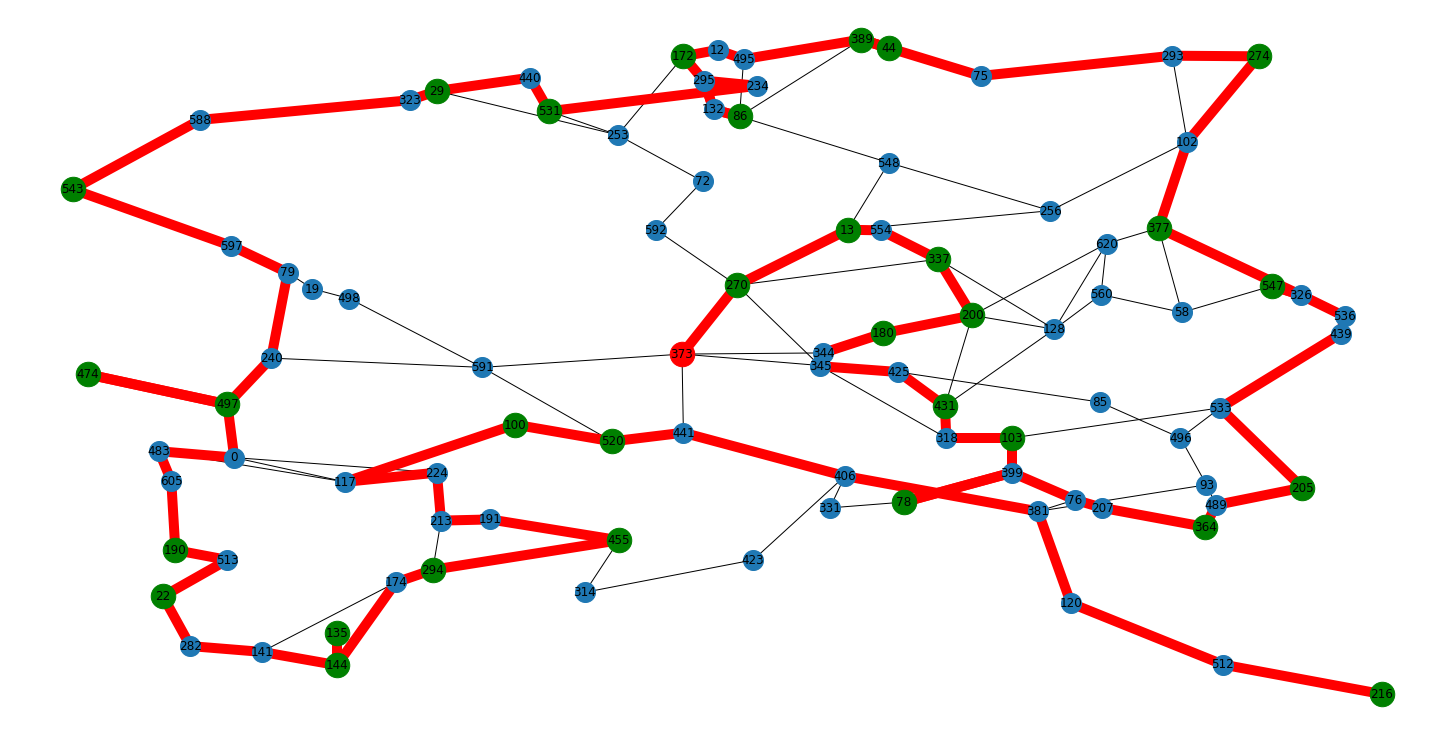

In [ ]:
G373=drawGraph(G, 373, nodes373, path373Final)


In [ ]:
backtodepot373=dict()
distRemSum373=0
costRemSum373=0
if len(fuelRequired)>0:
  sumCapacity, backtodepot373= fillRequiredLorries(373, remainingFuelRequired)
  lorry373.update(backtodepot373)
  print('sumCapacity=',sumCapacity,'\n', 'backtodepot373=',backtodepot373,'\n', 'lorry373=',lorry373)

  distSum373, costSum373= findTotalDistanceCost(lorry373)
  print(distSum373, costSum373)

  nodesRem373= [373]
  custNodes373=fuelRequired.keys()
  nodesRem373.extend(custNodes373)
  print(nodesRem373)
  pathRem373, visitedRem373, clRem373prev, totalLorryCapacityRem373, totalFuelRequirementRem373, clRem373, lorryRem373, destRem, distRemSum373, costRemSum373, remainingFuelRequired, fuelRequired= ExecuteDelivery(373, G373, nodesRem373, sumCapacity)
  print('path373Final= ', pathRem373,'\n', 'visited373=', visitedRem373, '\n','cl373prev=',clRem373prev,'\n', 'totalLorryCapacity373=',totalLorryCapacityRem373,'\n', 'totalFuelRequirement373=',totalFuelRequirementRem373,'\n', 'updatedcl373=',clRem373,'\n', 'lorry373=',lorryRem373,'\n', 'dest=',destRem,'\n', 'distSum=',distRemSum373,'\n', 'costSum=',costRemSum373,'\n', 'remainingFuelRequired=',remainingFuelRequired,'\n', 'fuelRequired=',fuelRequired)
  G373_rem=drawGraph(G373, 373, nodes373, pathRem373)


In [ ]:

if remainingFuelRequired==0:
  totalDistSum373=distSum373+distRemSum373
  totalCostSum373=costSum373+costRemSum373
  print(totalDistSum373, totalCostSum373)
  


1857.2010306736852 11829.540520536579


In [ ]:
path124Final, visited124, cl124prev, totalLorryCapacity124, totalFuelRequirement124, cl124, lorry124, dest, distSum124, costSum124, remainingFuelRequired, fuelRequired= ExecuteDelivery(124, G, custnodes124)
print('path124Final= ', path124Final,'\n', 'visited124=', visited124, '\n','cl124prev=',cl124prev,'\n', 'totalLorryCapacity124=',totalLorryCapacity124,'\n', 'totalFuelRequirement124=',totalFuelRequirement124,'\n', 'updatedcl124=',cl124,'\n', 'lorry124=',lorry124,'\n', 'dest=',dest,'\n', 'distSum=',distSum124,'\n', 'costSum=',costSum124,'\n', 'remainingFuelRequired=',remainingFuelRequired,'\n', 'fuelRequired=',fuelRequired)


length of customers 41
path124Final=  [124, 208, 14, 36, 14, 208, 204, 545, 11, 411, 106, 568, 507, 365, 67, 40, 403, 63, 71, 449, 614, 561, 245, 619, 321, 160, 92, 281, 81, 446, 81, 366, 43, 202, 272, 312, 374, 175, 4, 400, 4, 450, 566, 130, 566, 582, 245, 619, 288, 539, 298, 633, 260, 633, 298, 354, 565, 409, 262, 220, 262, 315, 552, 418, 384, 476, 397, 147, 171, 572, 521, 206, 254, 486, 15, 169, 303, 626, 339, 264, 509, 432, 105, 210, 105, 114, 615, 25, 214, 25, 615, 537, 292, 251, 369, 372, 227, 324, 452, 415, 359, 28, 606, 461, 104, 362, 430, 177, 118, 74, 379, 408, 379, 287, 89, 480, 36, 14, 208, 124, 542] 
 visited124= [124, 14, 36, 204, 411, 507, 63, 449, 245, 160, 446, 202, 374, 175, 400, 566, 130, 539, 633, 260, 220, 418, 476, 397, 147, 171, 206, 254, 169, 264, 105, 210, 214, 372, 324, 606, 362, 177, 118, 408, 542] 
 cl124prev= {0: [124, 124, 14, 22.330294086418878, 0.32999999999999996], 1: [124, 14, 36, 10.729563980425384, 0.81], 2: [124, 36, 204, 35.772106326153136, 0.69], 

In [ ]:
for node in path124Final:
  if node not in nodes124:
    nodes124.append(node)

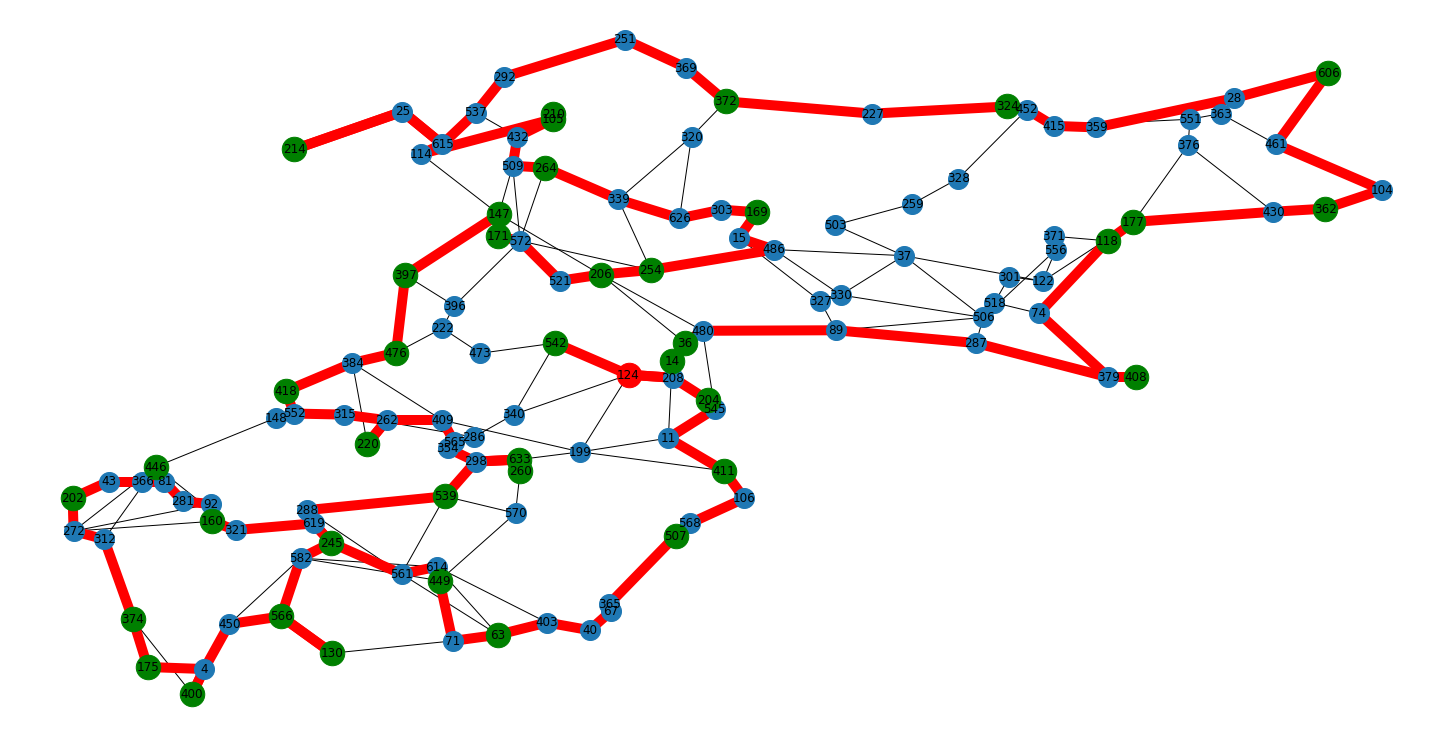

In [ ]:
G124=drawGraph(G, 124, nodes124, path124Final)

In [ ]:
backtodepot124=dict()
distRemSum124=0
costRemSum124=0
if len(fuelRequired)>0:
  sumCapacity, backtodepot124= fillRequiredLorries(124, remainingFuelRequired)
  lorry124.update(backtodepot124)
  print('sumCapacity=',sumCapacity,'\n', 'backtodepot124=',backtodepot124,'\n', 'lorry124=',lorry124)

  distSum124, costSum124= findTotalDistanceCost(lorry124)
  print(distSum124, costSum124)

  nodesRem124= [124]
  custNodes124=fuelRequired.keys()
  nodesRem124.extend(custNodes124)
  print(nodesRem124)
  pathRem124, visitedRem124, clRem124prev, totalLorryCapacityRem124, totalFuelRequirementRem124, clRem124, lorryRem124, destRem, distRemSum124, costRemSum124, remainingFuelRequired, fuelRequired= ExecuteDelivery(124, G124, nodesRem124, sumCapacity)
  print('path124Final= ', pathRem124,'\n', 'visited124=', visitedRem124, '\n','cl124prev=',clRem124prev,'\n', 'totalLorryCapacity124=',totalLorryCapacityRem124,'\n', 'totalFuelRequirement124=',totalFuelRequirementRem124,'\n', 'updatedcl124=',clRem124,'\n', 'lorry124=',lorryRem124,'\n', 'dest=',destRem,'\n', 'distSum=',distRemSum124,'\n', 'costSum=',costRemSum124,'\n', 'remainingFuelRequired=',remainingFuelRequired,'\n', 'fuelRequired=',fuelRequired)
  G124_rem=drawGraph(G124, 124, nodes124, pathRem124)



In [ ]:
if remainingFuelRequired==0:
  totalDistSum124=distSum124+distRemSum124
  totalCostSum124=costSum124+costRemSum124
  print(totalDistSum124, totalCostSum124)
  


2481.472202483174 21742.18242570245


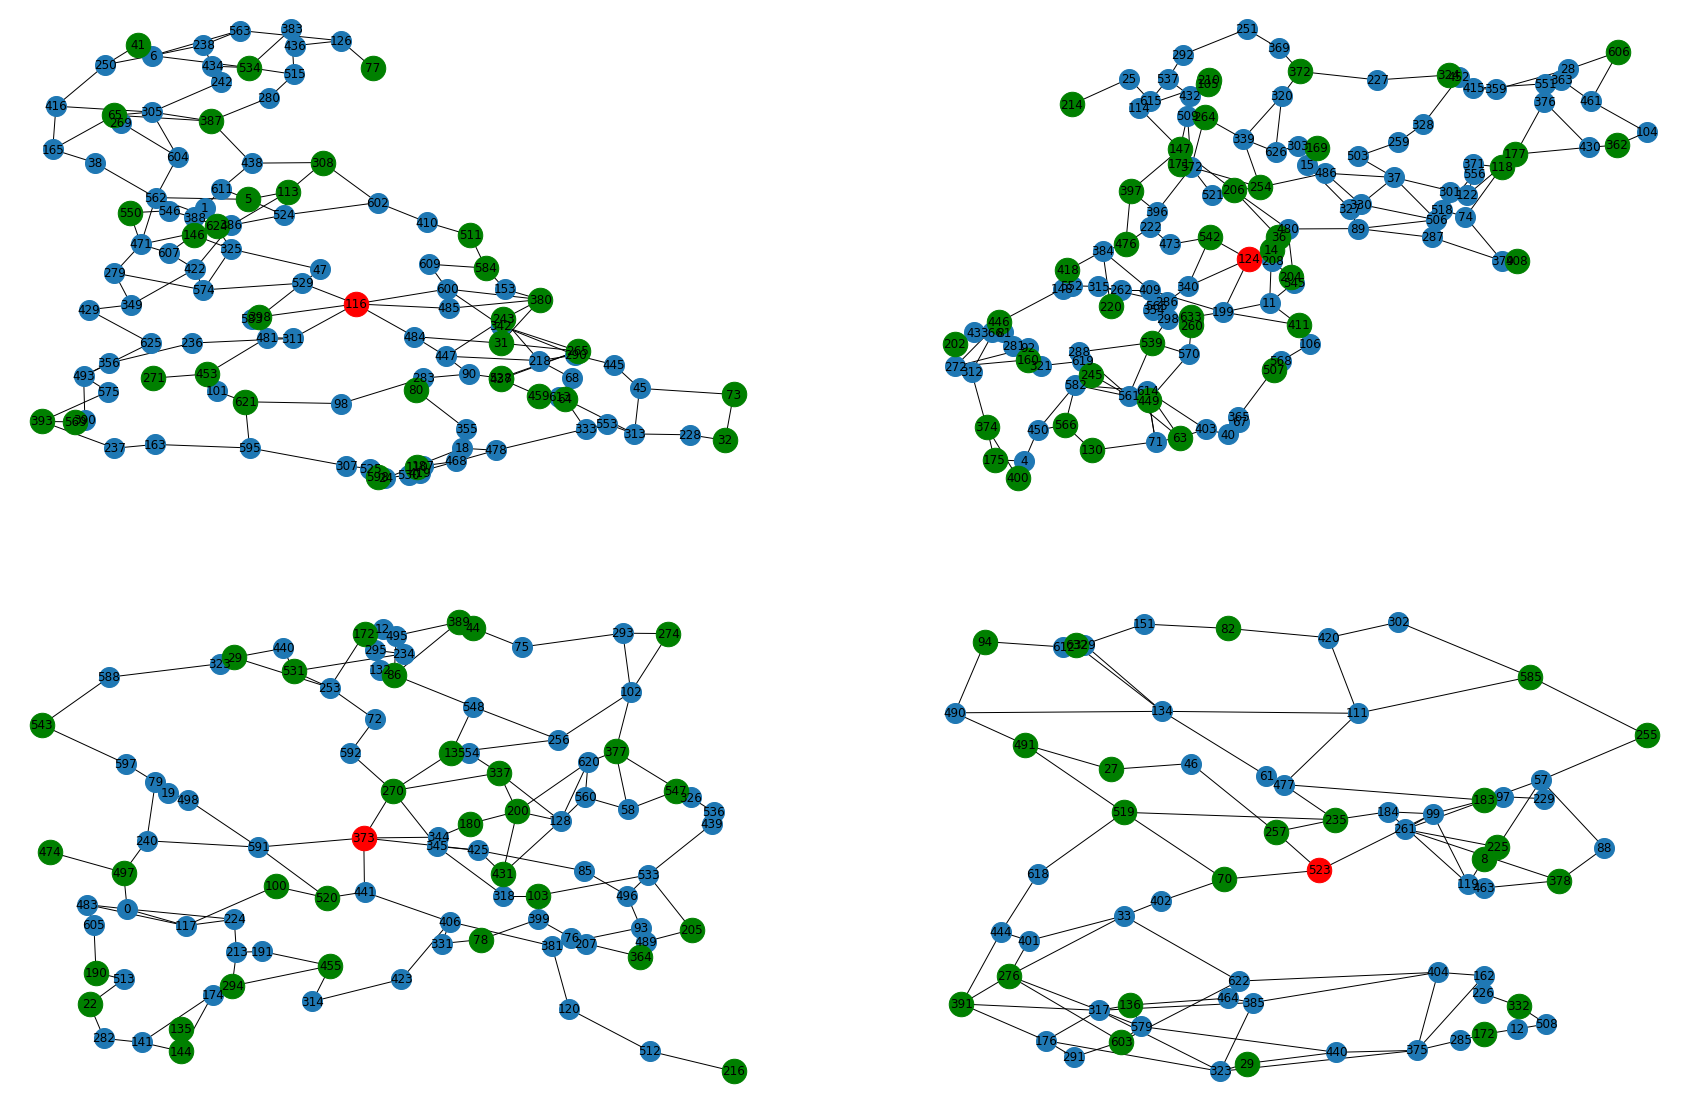

In [ ]:
fig,ax=plt.subplots(2,2, figsize=(30,20))

axis=ax.flatten()
# nx.draw_networkx(G116,ax=axis[0])
# nx.draw_networkx(G124,ax=axis[1])
# nx.draw_networkx(G373,ax=axis[2])
# nx.draw_networkx(G523,ax=axis[3])
nx.draw(G116,with_labels=False,pos=pos,node_size=400, ax=axis[0])
nx.draw_networkx_nodes(G116,pos,nodelist=[116],node_color='r',node_size=600,alpha=1,ax=axis[0]);
nx.draw_networkx_labels(G116,pos,{k:k for k in nodes116}, ax=axis[0]);
nx.draw_networkx_nodes(G116,pos,nodelist={k: k for k in cust_loc_ids if k not in [116] and k in nodes116},node_color='g',node_size=600,alpha=1, ax=axis[0]);

nx.draw(G124,with_labels=False,pos=pos,node_size=400, ax=axis[1])
nx.draw_networkx_nodes(G124,pos,nodelist=[124],node_color='r',node_size=600,alpha=1,ax=axis[1]);
nx.draw_networkx_labels(G124,pos,{k:k for k in nodes124}, ax=axis[1]);
nx.draw_networkx_nodes(G124,pos,nodelist={k: k for k in cust_loc_ids if k not in [124] and k in nodes124},node_color='g',node_size=600,alpha=1, ax=axis[1]);

nx.draw(G373,with_labels=False,pos=pos,node_size=400, ax=axis[2])
nx.draw_networkx_nodes(G373,pos,nodelist=[373],node_color='r',node_size=600,alpha=1,ax=axis[2]);
nx.draw_networkx_labels(G373,pos,{k:k for k in nodes373}, ax=axis[2]);
nx.draw_networkx_nodes(G373,pos,nodelist={k: k for k in cust_loc_ids if k not in [373] and k in nodes373},node_color='g',node_size=600,alpha=1, ax=axis[2]);

nx.draw(G523,with_labels=False,pos=pos,node_size=400, ax=axis[3])
nx.draw_networkx_nodes(G523,pos,nodelist=[523],node_color='r',node_size=600,alpha=1,ax=axis[3]);
nx.draw_networkx_labels(G523,pos,{k:k for k in nodes523}, ax=axis[3]);
nx.draw_networkx_nodes(G523,pos,nodelist={k: k for k in cust_loc_ids if k not in [523] and k in nodes523},node_color='g',node_size=600,alpha=1, ax=axis[3]);

plt.show()

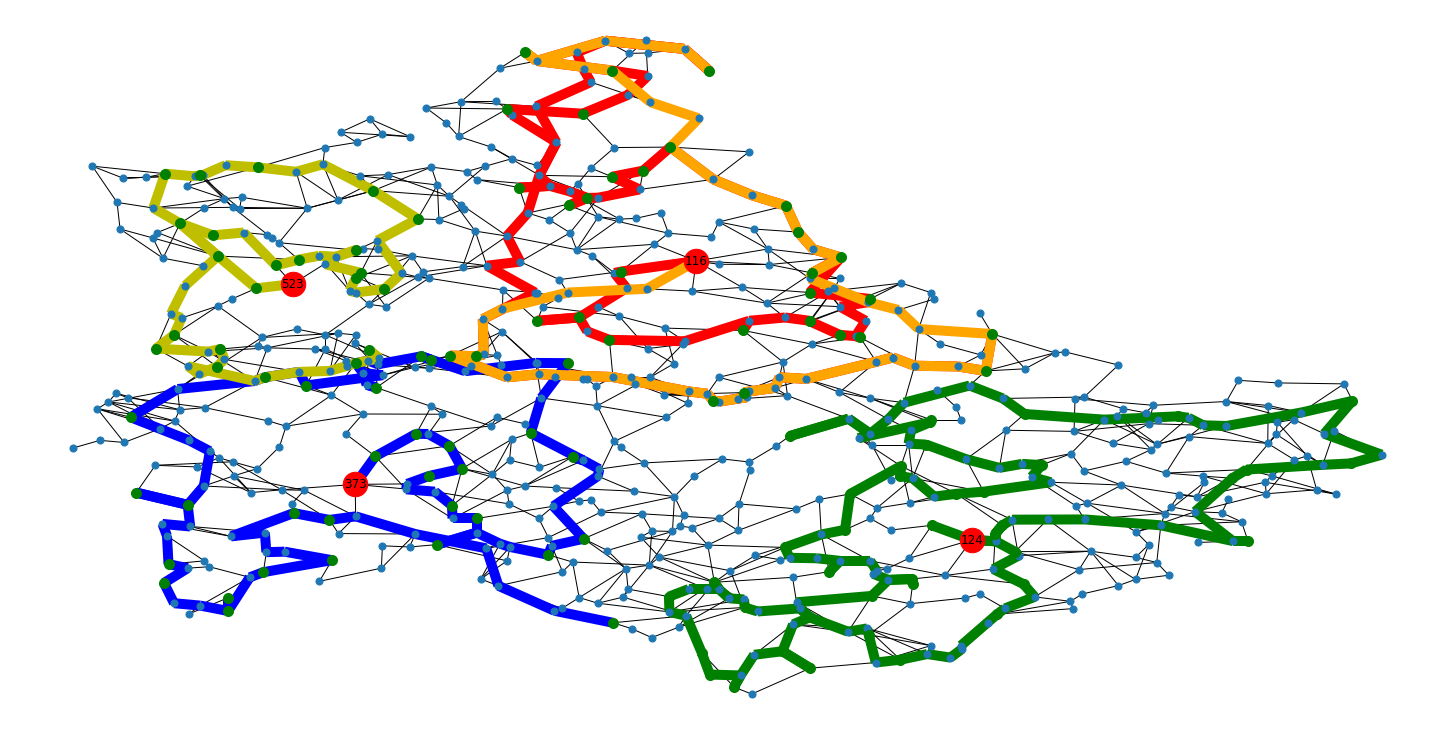

In [ ]:
Gnew=drawFullGraph()

In [ ]:

print(totalCostSum116, totalCostSum373, totalCostSum523, totalCostSum124)
totalCost=totalCostSum116+totalCostSum373+totalCostSum523+totalCostSum124
totalDist=totalDistSum116+ totalDistSum373+totalDistSum523+totalDistSum124
print(totalDist, totalCost)

#for sort by capacity desc: 
#19663.16 19674.51 9259.56 23615.510000000002
#8989.887442116687 72212.73999999999

#for sort by capacity ascending
#16914.129999999997 19932.879999999994 7984.580000000001 18362.679999999997
#9681.912928180365 63194.26999999999

#for sort by cptm asc
#19663.16 19674.51 9259.56 23615.510000000002 same as capacity desc
#8989.887442116687 72212.73999999999

#for sort by cpm asc
#16914.129999999997 19932.879999999994 7984.580000000001 18362.679999999997 same as capacity asc
#9681.912928180365 63194.26999999999

#For sort by capacity desc and  reduced fuel loaded (LEAST)
#15248.028418416932 11829.540520536579 5849.759809122749 21742.18242570245
#8009.295103224167 54669.51117377871

#For sort by capacity desc and  reduced fuel loaded - backtodepot in ascending order
# 20359.396326482245 11829.540520536579 5849.759809122749 21742.18242570245
# 8562.381917980085 59780.879081844025

15248.028418416932 11829.540520536579 5849.759809122749 21742.18242570245
8009.295103224167 54669.51117377871


In [ ]:
def printResult(depot, deliveryDetails):
  result=[]
  resultDict=dict()
  
  for (cust, lorry), value in deliveryDetails.items(): 
    #(cust, lorry-id):[lorry-id, capacity, delivered, quantity carried, dist, cost]
    #{"lorry_id": lorry-id, "loc":[cust, -delivered/+loaded]}
    loc=[]
    if '-depot' in lorry:
      loc.extend([depot, deliveryDetails[(cust, lorry)][3]])
      #loc=[depot, deliveryDetails[(cust, lorry)][3]])
      lorr="-".join(lorry.split("-", 2)[:2])
    elif '-to-depot' in lorry:
      loc.extend([depot, 0])
      lorr= "-".join(lorry.split("-", 2)[:2])
    else:
      loc.extend([cust, -deliveryDetails[(cust, lorry)][2]])
      lorr=lorry
    result.append({'lorry_id': lorr,"loc": loc})
  return result

In [ ]:
def sortByID(elem):
    return elem["lorry_id"]



In [ ]:
#Forming the json output

from itertools import groupby 
from itertools import chain

result1=printResult(116, lorry116)
result2=printResult(116, lorryRem116)
result3=printResult(124, lorry124)
result4=printResult(523, lorry523)
result5=printResult(373, lorry373)
result=[]
result.extend(result1)
result.extend(result2)
result.extend(result3)
result.extend(result4)
result.extend(result5)



In [ ]:
result.sort(key=sortByID)

groupedResult=[[{'lorry_id':k, 'loc':[x["loc"] for x in g]}] for k, g in groupby(result, key = lambda x: x["lorry_id"])]

flattened_result = [j for sublist in groupedResult for j in sublist] 

result_json=json.dumps(flattened_result)

print(result_json)

# with open(os.path.join(get_parent_dir(0), 'soln.txt'), 'w') as outfile:
#   json.dump(flattened_result, outfile)

[{"lorry_id": "116-0", "loc": [[116, 5], [146, -0.38999999999999946], [550, -0.45999999999999996], [65, -0.72], [387, -1.24], [534, -1.19], [41, -1.0000000000000004]]}, {"lorry_id": "116-1", "loc": [[116, 12], [398, -0.89], [453, -0.61], [271, -0.9], [621, -0.24], [80, -0.22999999999999998], [528, -0.12], [437, -0.94], [459, -1.98], [64, -0.96], [265, -0.48], [31, -0.56], [380, -0.15999999999999998], [243, -0.6699999999999999], [584, -0.21999999999999997], [511, -0.24], [308, -0.6799999999999999], [113, -0.44999999999999996], [5, -0.09999999999999998], [624, -0.51], [146, -1.0600000000000005], [116, 0], [116, 6.869999999999998], [569, -0.13], [393, -1.12], [598, -0.97], [110, -1.99], [32, -0.92], [73, -0.22999999999999998], [41, -0.029999999999999583], [77, -1.47]]}, {"lorry_id": "124-6", "loc": [[124, 22], [14, -0.32999999999999996], [36, -0.81], [204, -0.69], [411, -0.99], [507, -1.15], [63, -0.47], [449, -1.74], [245, -0.15000000000000002], [160, -0.91], [446, -0.94], [202, -0.17000

In [ ]:
#Checking if lall customers are satisfied

df_loc[(df_loc.is_customer==True) & (df_loc.emptiness==df_loc.filled)].count()

index          123
id             123
x              123
y              123
is_depot       123
is_customer    123
capacity       123
level          123
emptiness      123
emptinessP     123
filled         123
dtype: int64

In [ ]:
#Checking the toal fuel requirement
final=totalFuelRequirement116 + totalFuelRequirement124+ totalFuelRequirement373 + totalFuelRequirement523
print(final)

90.42


In [ ]:
#Output validatin and cost calculation:

def findJsonDistanceAndCost(lorry_id, loc, cpm, cptm):
  depot=loc[0][0]
  # distance=dist_graph[depot][loc[1][0]]
  quantity=loc[0][1]
  # totalDist=dist_graph[depot][loc[1][0]]
  # totalCost=distance*(cpm+ (quantity * cptm))
  # initialQuantity=loc[0][1]
  totalDist=0
  totalCost=0
  for i in range(len(loc)-1):
    distance=dist_graph[loc[i][0], loc[i+1][0]]
    if loc[i][1] >=0:
      # initialQuantity=loc[i][1]
      quantity=loc[i][1]
      cost=(distance*(cpm+ (quantity * cptm)))
      #print('+quantity:', quantity, 'node:', loc[i][0], ',',loc[i+1][0],'distance:', distance, 'cost:', cost)
      #print(distance, '* (',cpm,'+(', quantity, '*', cptm, '))' ) 
    else:
      quantity=quantity+ loc[i][1]
      cost=(distance*(cpm+ (quantity * cptm)))
      #print('quantity:', quantity, 'node:', loc[i][0], ',',loc[i+1][0],'distance:', distance, 'cost:', cost)      
      #print(distance, '* (',cpm,'+(', quantity, '*', cptm, '))' ) 
      
    totalDist=totalDist+distance
    totalCost=totalCost+cost

  return totalDist, totalCost



In [ ]:
def ValidateAndCalcCost(flattened_result):
  totalValDist=0
  totalValCost=0
  for lorry in flattened_result:
    #print(values['lorry_id'])
    cpm=pdjson[pdjson.lorry_id==lorry['lorry_id']]['cpm'].item()
    cptm=pdjson[pdjson.lorry_id==lorry['lorry_id']]['cptm'].item()
    capacity= pdjson[pdjson.lorry_id==lorry['lorry_id']]['capacity'].item()
    #print(lorry['lorry_id'], cpm,cptm, capacity)
    ValDist, ValCost=findJsonDistanceAndCost(lorry['lorry_id'], lorry['loc'], cpm, cptm)
    print('distance for ',lorry['lorry_id'],':', ValDist)
    print('Cost of',lorry['lorry_id'],':', ValCost)
    totalValDist=totalValDist+ValDist
    totalValCost=totalValCost+ValCost
  
#Number of customers
  cnt=0
  for lorry in flattened_result:
    for j in range(len(lorry['loc'])):
      #print(lorry['loc'][j][0])
      if lorry['loc'][j][0] in depot_loc_ids:
        #print(lorry['loc'][j])
        continue;
      else:
        #print(lorry['loc'][j][0])
        cnt=cnt+1
  print('cnt:', cnt)
  if (cnt>=123):
    validity='all customers OK'
  else:
    validity='error in customer count'


  #Fuel Requirement:
  FuelRequirement=df_loc[df_loc.is_customer==True]['emptiness'].sum()
  sum=0
  for lorry in flattened_result:
    for j in range(len(lorry['loc'])):
      #print(lorry['loc'][j][0])
      if lorry['loc'][j][0] in depot_loc_ids:
        #print(lorry['loc'][j])
        continue;
      else:
        #print(lorry['loc'][j][0])
        sum=sum-lorry['loc'][j][1]
  print('sum:', sum)
  print('Req:', FuelRequirement)
  if (round(sum,2)==round(FuelRequirement,2)):
    validity=validity+', Fuel Requirement OK'
  else:
    validity=validity+', Fuel Requirement error'
  return totalValDist, totalValCost, validity
#totalValDist, totalValCost=findJsonDistanceAndCost('116-0', lorry['loc'], cpm, cptm)

In [ ]:
#flattened_result=[{"lorry_id": "116-0", "loc": [[116, 5], [146, -0.38999999999999946], [550, -0.45999999999999996], [65, -0.72], [387, -1.24], [534, -1.19], [41, -1.0000000000000004]]}, {"lorry_id": "116-1", "loc": [[116, 12], [398, -0.89], [453, -0.61], [271, -0.9], [621, -0.24], [80, -0.22999999999999998], [528, -0.12], [437, -0.94], [459, -1.98], [64, -0.96], [265, -0.48], [31, -0.56], [380, -0.15999999999999998], [243, -0.6699999999999999], [584, -0.21999999999999997], [511, -0.24], [308, -0.6799999999999999], [113, -0.44999999999999996], [5, -0.09999999999999998], [624, -0.51], [146, -1.0600000000000005], [116, 0], [116, 12], [569, -0.13], [393, -1.12], [598, -0.97], [110, -1.99], [32, -0.92], [73, -0.22999999999999998], [41, -0.029999999999999583], [77, -1.47]]}, {"lorry_id": "124-6", "loc": [[124, 22], [14, -0.32999999999999996], [36, -0.81], [204, -0.69], [411, -0.99], [507, -1.15], [63, -0.47], [449, -1.74], [245, -0.15000000000000002], [160, -0.91], [446, -0.94], [202, -0.17000000000000004], [374, -0.5], [175, -1.63], [400, -0.19], [566, -0.26], [130, -1.19], [539, -0.28], [633, -0.18000000000000005], [260, -1.62], [220, -0.61], [418, -0.32999999999999996], [476, -0.31000000000000005], [397, -0.7], [147, -0.8500000000000001], [171, -1.3199999999999998], [206, -0.88], [254, -1.28], [169, -1.4], [264, -0.120000000000001]]}, {"lorry_id": "124-7", "loc": [[124, 22], [264, -0.7399999999999991], [105, -1.27], [210, -0.47], [214, -1.6099999999999999], [372, -1.75], [324, -0.42000000000000004], [606, -1.44], [362, -0.75], [177, -1.23], [118, -0.71], [408, -0.28], [542, -0.47]]}, {"lorry_id": "373-7", "loc": [[373, 22], [270, -0.21999999999999997], [13, -0.19999999999999996], [337, -0.44999999999999996], [200, -0.27], [180, -0.76], [431, -0.39], [103, -0.43999999999999995], [78, -0.63], [364, -0.89], [205, -0.9099999999999999], [547, -0.95], [377, -0.95], [274, -0.16999999999999993], [389, -0.07], [44, -0.71], [172, -0.91], [86, -1.03], [531, -0.10999999999999999], [543, -0.54], [497, -0.98], [474, -0.3999999999999999], [190, -0.3600000000000001], [22, -1.68], [144, -0.45999999999999996], [135, -1.33], [294, -0.81], [455, -0.3], [100, -1.02], [520, -0.44], [216, -0.27]]}, {"lorry_id": "523-4", "loc": [[523, 22], [70, -1.46], [519, -0.21000000000000002], [491, -0.33999999999999997], [27, -1.02], [257, -0.19999999999999996], [235, -0.36], [183, -0.3999999999999999], [225, -0.64], [8, -0.19999999999999996], [378, -0.54], [255, -0.16999999999999998], [585, -1.41], [82, -0.6], [632, -1.24], [94, -1.52], [276, -0.9299999999999999], [391, -1.0], [136, -0.33999999999999997], [603, -0.86], [29, -0.54], [332, -0.79]]}]

In [ ]:
totalValDist, totalValCost, validity=ValidateAndCalcCost(flattened_result)

print('Total Distance:', totalValDist, 'Total Cost:', totalValCost, 'Validity:', validity)

distance for  116-0 : 460.1286735005231
Cost of 116-0 : 2964.6695119946658
distance for  116-1 : 2168.9321597165554
Cost of 116-1 : 12283.380287874597
distance for  124-6 : 1317.6855949795236
Cost of 124-6 : 10013.552179557202
distance for  124-7 : 1163.7866075036504
Cost of 124-7 : 11728.626636430574
distance for  373-7 : 1857.2010306736852
Cost of 373-7 : 11829.51192464262
distance for  523-4 : 1041.5610368502312
Cost of 523-4 : 5849.754238672026
cnt: 126
sum: 90.42
Req: 90.42000000000002
Total Distance: 8009.295103224169 Total Cost: 54669.49477917168 Validity: all customers OK, Fuel Requirement OK


In [ ]:
# for item in nodes373:
#   if (item in nodes523) or (item in nodesRem116):
#     print(item)

172
12
440
29
323
